In [1]:
! pip install neuralogic
! pip install mlflow
! pip install optuna
! pip install torch_geometric
! pip install -Uqq ipdb
import ipdb
from neuralogic.nn import get_evaluator
from neuralogic.core import R, Template, V, Transformation, Aggregation
from neuralogic.core.settings import Settings
from neuralogic.dataset import Dataset
from neuralogic.optim import SGD
from neuralogic.utils.data import Mutagenesis
from neuralogic.core import Settings
from neuralogic.nn.loss import MSE
from neuralogic.nn import get_evaluator
from neuralogic.optim import Adam
import random
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import mlflow
from urllib.parse import urlparse
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/neuralogic/core/builder/builder.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [12]:
from neuralogic.core import R, Template, V
from neuralogic.utils.data import Mutagenesis
from torch_geometric.datasets import TUDataset
from neuralogic.dataset import TensorDataset, Data, FileDataset
from enum import Enum

class DatasetInfo:
    def __init__(self, node_embed, edge_embed, connection, atom_types, key_atom_type,
                 bond_types, single_bond, double_bond, triple_bond, aliphatic_bond, aromatic_bonds,
                 carbon, oxygen, hydrogen, nitrogen, sulfur,
                 halogens):
        # for key, value in kwargs.items():
        #     setattr(self, key, value)

        self.node_embed = node_embed
        self.edge_embed = edge_embed
        self.connection = connection
        self.atom_types = atom_types
        self.bond_types = bond_types
        self.key_atom_type = key_atom_type
        self.single_bond = single_bond
        self.double_bond = double_bond
        self.carbon = carbon
        self.aliphatic_bond = aliphatic_bond
        self.halogens = halogens
        self.triple_bond = triple_bond
        self.aromatic_bonds = aromatic_bonds
        self.oxygen = oxygen
        self.hydrogen = hydrogen
        self.nitrogen = nitrogen
        self.sulfur = sulfur

# def create_template(param_size, atom_types, bond_types, examples_file, queries_file, key_atoms, additional_info):
#     """
#     Create a generic template for a dataset.

#     :param param_size: Parameter size for embeddings.
#     :param atom_types: List of atom types.
#     :param bond_types: List of bond types.
#     :param examples_file: Path to the examples file.
#     :param queries_file: Path to the queries file.
#     :param key_atoms: List of key atoms.
#     :param additional_info: Additional information for DatasetInfo.
#     :return: A tuple containing the template, dataset, and DatasetInfo instance.
#     """
#     try:
#         dataset = FileDataset(examples_file=examples_file, queries_file=queries_file)
#     except FileNotFoundError as e:
#         raise Exception(f"File not found: {e}")

#     template = Template()

#     # Add rules for atom and bond embeddings
#     template.add_rules([(R.atom_embed(V.A)[param_size,] <= R.get(atom)(V.A)) for atom in atom_types])
#     template.add_rules([(R.bond_embed(V.B)[param_size,] <= R.get(bond)(V.B)) for bond in bond_types])

#     return template, dataset, DatasetInfo(*additional_info)

def MutagenesisTemplate(param_size):
    """
    Create a template for the Mutagenesis dataset.

    :param param_size: Parameter size for embeddings.
    :return: A tuple containing the template, dataset, and DatasetInfo instance.
    """
    _, dataset = Mutagenesis()
    template = Template()

    # Define atom and bond types
    atom_types = ["c", "o", "br", "i", "f", "h", "n", "cl"]
    key_atoms = ["o", "s", "n"]
    bond_types = ["b_1", "b_2", "b_3", "b_4", "b_5", "b_7"]

    # Add rules for atom embeddings
    template.add_rules([
        (R.atom_embed(V.A)[param_size,] <= R.get(atom)(V.A)) for atom in atom_types
    ])

    # Add rules for bond embeddings
    template.add_rules([
        (R.bond_embed(V.B)[param_size,] <= R.get(bond)(V.B)) for bond in bond_types
    ])

    return template, dataset, DatasetInfo("atom_embed", "bond_embed", "bond", atom_types, key_atoms, bond_types,
                                          "b_1", "b_2", "b_3",  ["b_1", "b_2", "b_3"], ["b_4", "b_5", "b_6", "b_7"],
                                          "c", "o", "h", "n", "s", ["f", "cl", "br", "i"])


def PTCTemplate(param_size):
    """
    Create a template for the PTC dataset.

    :param param_size: Parameter size for embeddings.
    :return: A tuple containing the template, dataset, and DatasetInfo instance.
    """
    dataset = FileDataset(examples_file="datasets/ptc_examples.txt", queries_file="datasets/ptc_queries.txt")
    template = Template()

    # Define atom and bond types
    atom_types = [f"atom_{i}" for i in range(18)]
    key_atoms = ["atom_1", "atom_2", "atom_3", "atom_7"]
    bond_types = ["b_1", "b_2", "b_3", "b_0"]

    # Add rules for atom embeddings
    template.add_rules([
        (R.bond_embed(V.B)[param_size,] <= R.get(bond)(V.B)) for bond in bond_types
    ])

    # Add rules for bond embeddings
    template.add_rules([
        (R.atom_embed(V.A)[param_size,] <= R.get(atom)(V.A)) for atom in atom_types
    ])

    return template, dataset, DatasetInfo("atom_embed", "bond_embed", "bond", atom_types, key_atoms, bond_types,
                                          "b_2", "b_1", "b_0",  ["b_0", "b_1", "b_2"], ["b_3"],
                                          "atom_5", "atom_2", "h", "atom_3", "atom_7", ["atom_9", "atom_6", "atom_8", "atom_13"])

def PTCFRTemplate(param_size):
    dataset = FileDataset(examples_file="datasets/ptcfr_examples.txt", queries_file="datasets/ptcfr_queries.txt")

    template = Template()

    atom_types = [f"atom_{i}" for i in range(19)]
    key_atoms = ["atom_1", "atom_2", "atom_3", "atom_7"]
    bond_types = ["b_1", "b_2", "b_3", "b_0"]

    template.add_rules([
        (R.bond_embed(V.B)[param_size,] <= R.get(bond)(V.B)) for bond in bond_types
    ])

    template.add_rules([
        (R.atom_embed(V.A)[param_size,] <= R.get(atom)(V.A)) for atom in atom_types
    ])

    return template, dataset, DatasetInfo("atom_embed", "bond_embed", "bond", atom_types, key_atoms, bond_types,
                                          "b_2", "b_1", "b_0",  ["b_0", "b_1", "b_2"], ["b_3"],
                                          "atom_5", "atom_2", "h", "atom_3", "atom_7", ["atom_9", "atom_6", "atom_8", "atom_14"])

def PTCFMTemplate(param_size):
    dataset = FileDataset(examples_file="datasets/ptcfm_examples.txt", queries_file="datasets/ptcfm_queries.txt")

    template = Template()

    atom_types = [f"atom_{i}" for i in range(18)]
    key_atoms = ["atom_1", "atom_4", "atom_3", "atom_6"]
    bond_types = ["b_1", "b_2", "b_3", "b_0"]

    template.add_rules([
        (R.bond_embed(V.B)[param_size,] <= R.get(bond)(V.B)) for bond in bond_types
    ])

    template.add_rules([
        (R.atom_embed(V.A)[param_size,] <= R.get(atom)(V.A)) for atom in atom_types
    ])

    return template, dataset, DatasetInfo("atom_embed", "bond_embed", "bond", atom_types, key_atoms, bond_types,
                                          "b_1", "b_1", "b_0",  ["b_0", "b_1", "b_2"], ["b_3"],
                                          "atom_2", "atom_3", "h", "atom_4", "atom_6", ["atom_9", "atom_5", "atom_7", "atom_13"])

def PTCMMTemplate(param_size):
    dataset = FileDataset(examples_file="datasets/ptcmm_examples.txt", queries_file="datasets/ptcmm_queries.txt")

    template = Template()

    atom_types = [f"atom_{i}" for i in range(20)]
    key_atoms = ["atom_1", "atom_2", "atom_3", "atom_7"]
    bond_types = ["b_1", "b_2", "b_3", "b_0"]

    template.add_rules([
        (R.bond_embed(V.B)[param_size,] <= R.get(bond)(V.B)) for bond in bond_types
    ])

    template.add_rules([
        (R.atom_embed(V.A)[param_size,] <= R.get(atom)(V.A)) for atom in atom_types
    ])

    return template, dataset, DatasetInfo("atom_embed", "bond_embed", "bond", atom_types, key_atoms, bond_types,
                                          "b_2", "b_1", "b_0",  ["b_0", "b_1", "b_2"], ["b_3"],
                                          "atom_5", "atom_2", "h", "atom_3", "atom_7", ["atom_9", "atom_6", "atom_8", "atom_15"])


def COXTemplate(param_size):
    dataset = FileDataset(examples_file="datasets/cox_examples.txt", queries_file="datasets/cox_queries.txt")

    template = Template()

    atom_types = [f"atom_{i}" for i in range(7)]
    key_atoms = ["atom_1", "atom_4", "atom_3"]
    bond_types = ["b_4", "b_2", "b_3", "b_0", "b_1"]

    template.add_rules([
        (R.bond_embed(V.B)[param_size,] <= R.get(bond)(V.B)) for bond in bond_types
    ])

    template.add_rules([
        (R.atom_embed(V.A)[param_size,] <= R.get(atom)(V.A)) for atom in atom_types
    ])

    return template, dataset, DatasetInfo("atom_embed", "bond_embed", "bond", atom_types, key_atoms, bond_types,
                                          "b_2", "b_3", "b_4", ["b_2", "b_3", "b_4"], ["b_0"],
                                          "atom_0", "atom_4", "h", "atom_1", "atom_3", ["atom_2", "atom_5", "atom_6"])
def DHFRTemplate(param_size):
    dataset = FileDataset(examples_file="datasets/dhfr_examples.txt", queries_file="datasets/dhfr_queries.txt")

    template = Template()

    atom_types = [f"atom_{i}" for i in range(7)]
    key_atoms = ["atom_0", "atom_5", "atom_3"]
    bond_types = ["b_4", "b_2", "b_3", "b_0", "b_1"]

    template.add_rules([
        (R.bond_embed(V.B)[param_size,] <= R.get(bond)(V.B)) for bond in bond_types
    ])

    template.add_rules([
        (R.atom_embed(V.A)[param_size,] <= R.get(atom)(V.A)) for atom in atom_types
    ])

    return template, dataset, DatasetInfo("atom_embed", "bond_embed", "bond", atom_types, key_atoms, bond_types,
                                          "b_2", "b_3", "b_4", ["b_2", "b_3", "b_4"], ["b_0"],
                                          "atom_1", "atom_3", "h", "atom_0", "atom_5", ["atom_2", "atom_4", "atom_6"])

def ERTemplate(param_size):
    dataset = FileDataset(examples_file="datasets/er_examples.txt", queries_file="datasets/er_queries.txt")

    template = Template()

    atom_types = [f"atom_{i}" for i in range(10)]
    key_atoms = ["atom_1", "atom_2", "atom_4", "atom_9"]
    bond_types = ["b_4", "b_2", "b_3", "b_0", "b_1"]

    template.add_rules([
        (R.bond_embed(V.B)[param_size,] <= R.get(bond)(V.B)) for bond in bond_types
    ])

    template.add_rules([
        (R.atom_embed(V.A)[param_size,] <= R.get(atom)(V.A)) for atom in atom_types
    ])

    return template, dataset, DatasetInfo("atom_embed", "bond_embed", "bond", atom_types, key_atoms, bond_types,
                                          "b_2", "b_3", "b_4", ["b_2", "b_3", "b_4"], ["b_0"],
                                          "atom_0", "atom_1", "h", "atom_2", "atom_4", ["atom_3", "atom_5", "atom_6", "atom_8"])


# MUTAGENESIS = "mutagen"
# PTC = "ptc"
# PTCFR = "ptc_fr"
# PTCMM = "ptc_mm"
# PTCFM = "ptc_fm"
# COX = "cox"
# DHFR = "dhfr"
# ER = "er"

dataset_templates = {
    "mutagen": MutagenesisTemplate,
    "ptc": PTCTemplate,
    "ptc_fr": PTCFRTemplate,
    "ptc_mm": PTCMMTemplate,
    "ptc_fm": PTCFMTemplate,
    "cox": COXTemplate,
    "dhfr": DHFRTemplate,
    "er": ERTemplate
}


# def get_dataset(dataset, param_size):
#     if dataset == MUTAGENESIS:
#         return MutagenesisTemplate(param_size)
#     elif dataset == PTC:
#         return PTCTemplate(param_size)
#     elif dataset == PTCFR:
#         return PTCFRTemplate(param_size)
#     elif dataset == PTCFM:
#         return PTCFMTemplate(param_size)
#     elif dataset == PTCMM:
#         return PTCMMTemplate(param_size)
#     elif dataset == COX:
#         return COXTemplate(param_size)
#     elif dataset == DHFR:
#         return DHFRTemplate(param_size)
#     elif dataset == ER:
#         return ERTemplate(param_size)
#     else:
#         raise Exception("Invalid dataset name")

def get_dataset(dataset, param_size):
    """
    Get the dataset template based on the dataset name and parameter size.

    :param dataset: Name of the dataset.
    :param param_size: Size of the parameter for the dataset template.
    :return: An instance of the corresponding dataset template class.
    :raises ValueError: If the dataset name is invalid.
    """
    # Retrieve the template class from the dictionary
    template_class = dataset_templates.get(dataset)

    if template_class is None:
        raise ValueError(f"Invalid dataset name: {dataset}\nPlease use one of the following: {list(dataset_templates.keys())}")

    # Instantiate and return the template class
    return template_class(param_size)

In [3]:
from neuralogic.nn import get_evaluator
from neuralogic.core import R, Template, V, Transformation, Aggregation, Combination
from neuralogic.core.settings import Settings
from neuralogic.dataset import Dataset
from neuralogic.optim import SGD
from neuralogic.utils.data import Mutagenesis

# GNN = "gnn"
# RGCN = "rgcn"
# KGNN_LOCAL = "kgnn_local"
# KGNN_GLOBAL = "kgnn"
# EGO_GNN = "ego"
# GATED_GNN = "gated_gnn"
# DIFFUSION = "diffusion"
# CWN = "cw_net"
# SUBGRAPH = "sgn"


# def get_model(model, model_name, layers, node_embed, edge_embed, connection, param_size, node_types=None,
#               edge_types=None, max_depth=1):
#     """
#         Parameters
#         ----------
#         model: type of the model
#         model_name: name for the model
#         layers: number of layers
#         node_embed: embedding for the nodes
#         edge_embed: embedding for the edges
#         connection: connection predicate, expects connection(X, Y, E), where X and Y are nodes and E is edge
#         param_size: int parameter size of the embeddings
#         edge_types: list of strings representing predicates defining edge types
#         Returns
#         -------
#         template: a list of rules defining the model
#         """
#     if model == GNN:
#         return StandardGNN_model(model_name, layers, node_embed, edge_embed, connection, param_size)
#     elif model == RGCN:
#         return RGCN_model(model_name, layers, node_embed, edge_embed, connection, param_size, edge_types)
#     elif model == KGNN_LOCAL:
#         return KGNN_model(model_name, layers, node_embed, param_size, edge_embed, connection, local=True)
#     elif model == KGNN_GLOBAL:
#         return KGNN_model(model_name, layers, node_embed, param_size, local=False)
#     elif model == EGO_GNN:
#         return EgoGNN_model(model_name, layers, node_embed, edge_embed, connection, param_size)
#     elif model == GATED_GNN:
#         return GatedGNN_model(model_name, layers, node_embed, edge_embed, connection, param_size, max_depth)
#     elif model == DIFFUSION:
#         return DiffusionCNN_model(model_name, layers, node_embed, edge_embed, connection, param_size, max_depth)
#     elif model == CWN:
#       return CWNet_model(model_name, layers, node_embed, edge_embed, connection, param_size, max_depth)
#     elif model == SUBGRAPH:
#         return SGN_model(model_name, layers, node_embed, edge_embed, connection, param_size, max_depth)
#     else:
#         raise Exeption("Invalid model name")


def StandardGNN_model(model_name: str, layers: int, node_embed: str, edge_embed: str, connection: str, param_size: int):
    def get_gnn(layer_name: str, node_embed: str, param_size: tuple):
        return [(R.get(layer_name)(V.X) <= (R.get(node_embed)(V.X)[param_size],
                                            R.get(node_embed)(V.Y)[param_size],
                                            R.get(connection)(V.X, V.Y, V.B), R.get(edge_embed)(V.B)))]

    template = [(R.get(f"{model_name}_GNN_0")(V.X) <= R.get(node_embed)(V.X))]
    for i in range(layers):
        template += get_gnn(f"{model_name}_GNN_{i + 1}", f"{model_name}_GNN_{i}", (param_size, param_size))

    template += [(R.get(f"{model_name}_GNN")(V.X) <= R.get(f"{model_name}_GNN_{layers}")(V.X))]
    template += [(R.predict[1, param_size] <= R.get(f"{model_name}_GNN")(V.X))]

    return template


def RGCN_model(model_name: str, layers: int, node_embed: str, edge_embed: str, connection: str, param_size: int,
               edge_types):
    def get_rgcn(layer_name: str, node_embed: str, param_size: tuple):
        return [(R.get(layer_name)(V.X) <= (R.get(node_embed)(V.X)[param_size],
                                           R.get(node_embed)(V.Y)[param_size],
                                           R.get(connection)(V.X, V.Y, V.B),
                                           R.get(edge_embed)(V.B),
                                           R.get(f"{model_name}_RGCN_edge_types")(V.B)[param_size]))]

    template = [(R.get(f"{model_name}_RGCN_0")(V.X) <= R.get(node_embed)(V.X))]

    for t in edge_types:
        template.append((R.get(f"{model_name}_RGCN_edge_types")(V.B) <= R.get(t)(V.B)[param_size,]))

    for i in range(layers):
        template += get_rgcn(f"{model_name}_RGCN_{i + 1}", f"{model_name}_RGCN_{i}", (param_size, param_size))

    template += [(R.get(f"{model_name}_RGCN")(V.X) <= R.get(f"{model_name}_RGCN_{layers}")(V.X))]
    template += [(R.predict[1, param_size] <= R.get(f"{model_name}_RGCN")(V.X))]

    return template


def KGNN_model(model_name: str, layers: int, node_embed: str, param_size: int,
               edge_embed: str = None, connection: str = None, local=True):
    def get_k_set(layer_name: str, prev_layer: str, param_size: tuple):
        body = [R.get(node_embed)(V.X)[param_size],
                R.get(prev_layer)(V.Y)[param_size]]
        if local:
            body += [R.get(connection)(V.X, V.Y, V.B),
                     R.get(edge_embed)(V.B)[param_size]]

        return [R.get(layer_name)(V.X) <= body]

    template = [(R.get(f"{model_name}_kGNN_0")(V.X) <= (R.get(node_embed)(V.X)))]

    for i in range(layers):
        template += get_k_set(f"{model_name}_kGNN_{i + 1}", f"{model_name}_kGNN_{i}", (param_size, param_size))

    template += [(R.get(f"{model_name}_kGNN")(V.X) <= R.get(f"{model_name}_kGNN_{layers}")(V.X))]
    template += [(R.predict[1, param_size] <= R.get(f"{model_name}_kGNN")(V.X))]

    return template


def EgoGNN_model(model_name: str, layers: int, node_embed: str,
                 edge_embed: str, connection: str, param_size: int):
    def get_ego(layer_name: str, node_embed: str, param_size: tuple):
        template = []
        template += [R.get(layer_name + "_multigraph")(V.X) <= (
                     R.get(connection)(V.X, V.Y, V.B),
                     R.get(edge_embed)(V.B)[param_size],
                     R.get(node_embed)(V.Y)[param_size])]

        template += [R.get(layer_name)(V.X) <= (
                     R.get(connection)(V.X, V.Y, V.B),
                     R.get(layer_name + "_multigraph")(V.Y)[param_size])]
        return template

    template = [(R.get(f"{model_name}_ego_0")(V.X) <= (R.get(node_embed)(V.X)))]

    for i in range(layers):
        template += get_ego(f"{model_name}_ego_{i + 1}", f"{model_name}_ego_{i}", (param_size, param_size))

    template += [(R.get(f"{model_name}_ego")(V.X) <= R.get(f"{model_name}_ego_{layers}")(V.X))]
    template += [(R.predict[1, param_size] <= R.get(f"{model_name}_ego")(V.X))]

    return template


def GatedGNN_model(model_name: str, layers: int, node_embed: str,
                 edge_embed: str, connection: str, param_size: int, max_depth=1):
    def get_gated_gnn(layer_name, node_embed, param_size):
        template = []
        template += [(R.get(layer_name + "_h")(V.X, 0) <= (R.get(node_embed)(V.X)[param_size]))]

        template += [(R.get(layer_name + "_a_in")(V.X, V.T) <= (R.get(connection)(V.X, V.Y, V.B),
                                                                R.get(edge_embed)(V.B)[param_size],
                                                                R.get(layer_name + "_h")(V.Y, V.Z)[param_size],
                                                                R.special.next(V.Z, V.T))) | [Aggregation.SUM,
                                                                                              Transformation.IDENTITY]]

        template += [(R.get(layer_name + "_a_out")(V.X, V.T) <= (R.get(connection)(V.X, V.Y, V.B),
                                                                 R.get(edge_embed)(V.B)[param_size],
                                                                 R.get(layer_name + "_h")(V.Y, V.Z)[param_size],
                                                                 R.special.next(V.Z, V.T))) | [Aggregation.SUM,
                                                                                               Transformation.IDENTITY]]

        template += [
            (R.get(layer_name + "_update_gate")(V.X, V.T) <= (R.get(layer_name + "_a_in")(V.X, V.T)[param_size],
                                                              R.get(layer_name + "_a_out")(V.X, V.T)[param_size],
                                                              R.get(layer_name + "_h")(V.X, V.Z)[param_size],
                                                              R.special.next(V.Z, V.T))) | [Transformation.SIGMOID]]

        template += [(R.get(layer_name + "_reset_gate")(V.X, V.T) <= (R.get(layer_name + "_a_in")(V.X, V.T)[param_size],
                                                                      R.get(layer_name + "_a_out")(V.X, V.T)[
                                                                          param_size],
                                                                      R.get(layer_name + "_h")(V.X, V.Z)[param_size],
                                                                      R.special.next(V.Z, V.T))) | [
                         Transformation.SIGMOID]]

        template += [(R.get(layer_name + "_h_tright")(V.X, V.T) <= (R.get(layer_name + "_reset_gate")(V.X, V.T),
                                                                    R.get(layer_name + "_h")(V.X, V.Z),
                                                                    R.special.next(V.Z, V.T))) | [
                         Transformation.IDENTITY, Combination.ELPRODUCT]]

        template += [(R.get(layer_name + "_h_tilde")(V.X, V.T) <= (R.get(layer_name + "_a_in")(V.X, V.T)[param_size],
                                                                   R.get(layer_name + "_a_out")(V.X, V.T)[param_size],
                                                                   R.get(layer_name + "_h_tright")(V.X, V.T)[
                                                                       param_size])) | [Transformation.TANH,
                                                                                        Aggregation.SUM]]

        template += [(R.get(layer_name + "_h_right")(V.X, V.T) <= (R.get(layer_name + "_update_gate")(V.X, V.T),
                                                                   R.get(layer_name + "_h_tilde")(V.X, V.T))) | [
                         Transformation.IDENTITY, Combination.ELPRODUCT]]

        template += [(R.get(layer_name + "_h_left")(V.X, V.T) <= (R.get(layer_name + "_update_gate")(V.X, V.T),
                                                                  R.get(layer_name + "_h")(V.X, V.Z),
                                                                  R.special.next(V.Z, V.T))) | [Transformation.IDENTITY,
                                                                                                Combination.ELPRODUCT]]

        template += [(R.get(layer_name + "_h")(V.X, V.T) <= (R.get(layer_name + "_h_left")(V.X, V.T),
                                                             R.get(layer_name + "_h_right")(V.X, V.T))) | [
                         Aggregation.SUM, Transformation.IDENTITY]]

        template += [(R.get(layer_name)(V.X) <= R.get(layer_name + "_h")(V.X, max_depth))]
        return template

    template = [(R.get(f"{model_name}_gated_0")(V.X) <= (R.get(node_embed)(V.X)))]

    for i in range(max_depth):
        template += [(R._next(i, i + 1))]

    for i in range(layers):
        template += get_gated_gnn(f"{model_name}_gated_{i + 1}", f"{model_name}_gated_{i}", (param_size, param_size))

    template += [(R.get(f"{model_name}_gated")(V.X) <= R.get(f"{model_name}_gated_{layers}")(V.X))]
    template += [(R.predict[1, param_size] <= R.get(f"{model_name}_gated")(V.X))]

    return template



def DiffusionCNN_model(model_name: str, layers: int, node_embed: str,
                 edge_embed: str, connection: str, param_size: int, max_depth: int):
    def get_path(layer_name: str, param_size: tuple):
        template = []
        template += [
            R.get(layer_name)(V.X, V.Y, 0) <= (R.get(edge_embed)(V.B)[param_size], R.get(connection)(V.X, V.Y, V.B))]
        template += [R.get(layer_name)(V.X, V.Y, V.T) <= (R.get(edge_embed)(V.B)[param_size],
                                                          R.get(layer_name)(V.Z, V.Y, V.T1)[param_size],
                                                          R.get(connection)(V.X, V.Z, V.B),
                                                          R.special.next(V.T1, V.T))]

        for i in range(max_depth):
            template += [(R._next(i, i + 1))]

        template += [R.get(layer_name)(V.X, V.Y) <= (R.get(layer_name)(V.X, V.Y, max_depth))]

        return template

    def get_diffusion(layer_name: str, node_embed: str, param_size: tuple):
        template = []
        template += [
            (R.get(layer_name + "_Z")(V.X) <= (R.get(f"{model_name}_diff_path")(V.X, V.Y), R.get(node_embed)(V.Y)[param_size])) | [
                Aggregation.SUM]]
        template += [R.get(layer_name + "_Z")(V.X) <= R.get(node_embed)(V.X)[param_size]]
        template += [
            (R.get(layer_name)(V.X) <= (R.get(layer_name + "_Z")(V.X))) | [Transformation.SIGMOID, Aggregation.SUM]]

        return template

    template = [(R.get(f"{model_name}_diff_0")(V.X) <= (R.get(node_embed)(V.X)))]
    template += get_path(f"{model_name}_diff_path", (param_size, param_size))

    for i in range(layers):
        template += get_diffusion(f"{model_name}_diff_{i + 1}", f"{model_name}_diff_{i}", (param_size, param_size))

    template += [(R.get(f"{model_name}_diff")(V.X) <= R.get(f"{model_name}_diff_{layers}")(V.X))]
    template += [(R.predict[1, param_size] <= R.get(f"{model_name}_diff")(V.X))]

    return template




def CWNet_model(model_name: str, layers: int, node_embed: str,
                edge_embed: str, connection: str, param_size: int, max_ring_size: int = 7):
    def bottom_up_features(layer_name: str, prev_layer: str, param_size: tuple):
        template = []
        # atoms aggregate to bonds, bonds to rings
        template += [R.get(layer_name + "_bond_features")(V.B) <= (R.get(connection)(V.X, V.Y, V.B),
                                                                   R.get(f"{prev_layer}_node")(V.X)[param_size],
                                                                   R.get(f"{prev_layer}_node")(V.Y)[param_size])]

        # bonds in same cycle
        def get_bond_cycle(n):
            body = [R.get(connection)(f"X{i}", f"X{(i + 1) % n}", f"B{i}") for i in range(n)]
            body.extend(R.get(f"{prev_layer}_edge")(f"B{i}")[param_size] for i in range(n))
            body.append(R.special.alldiff(...))
            return [R.get(layer_name + "_cycle_features") <= body]

        for i in range(3, max_ring_size):
            template += get_bond_cycle(i)

        template += [R.get(layer_name + "_features")(V.B) <= (R.get(layer_name + "_bond_features")(V.B)[param_size])]
        template += [R.get(layer_name + "_features")(V.X) <= (R.get(layer_name + "_cycle_features")[param_size])]
        return template

    def top_down_features(layer_name: str, prev_layer: str, param_size: tuple):
        template = []

        def get_cycle_messages(n):
            body = [R.get(connection)(f"X{i}", f"X{(i + 1) % n}", f"B{i}") for i in range(n)]
            body.extend(R.get(f"{prev_layer}_edge")(f"B{i}")[param_size] for i in range(n))
            body.append(R.special.alldiff(...))

            return [R.get(layer_name + "_cycle_message")(V.B0) <= body]

        for i in range(3, max_ring_size):
            template += get_cycle_messages(i)

        # atoms sharing a bond share messages, bonds in the same ring
        template += [R.get(layer_name + "_atom_nbhood")(V.X) <= (R.get(connection)(V.X, V.Y, V.B),
                                                                 R.get(f"{prev_layer}_node")(V.Y)[param_size],
                                                                 R.get(layer_name + "_bond_nbhood")(V.B)[param_size])]
        template += [R.get(layer_name + "_bond_nbhood")(V.B) <= (R.get(layer_name + "_cycle_message")(V.B)[param_size])]

        template += [R.get(layer_name + "_nbhood")(V.B) <= (R.get(layer_name + "_bond_nbhood")(V.B)[param_size])]
        template += [R.get(layer_name + "_nbhood")(V.B) <= (R.get(layer_name + "_atom_nbhood")(V.B)[param_size])]
        return template

    def get_cw(layer_name: str, prev_layer: str, param_size: tuple):
        template = []
        template += bottom_up_features(layer_name, prev_layer, param_size)
        template += top_down_features(layer_name, prev_layer, param_size)

        template += [R.get(layer_name)(V.X) <= (R.get(layer_name + "_nbhood")(V.X)[param_size])]
        template += [R.get(layer_name)(V.X) <= (R.get(layer_name + "_features")(V.X)[param_size])]

        template += [R.get(layer_name + "_node")(V.X) <= (R.get(node_embed)(V.X)[param_size])]
        template += [R.get(layer_name + "_node")(V.X) <= (R.get(layer_name)(V.X)[param_size])]
        template += [R.get(layer_name + "_node")(V.X) <= (R.get(prev_layer + "_node")(V.X)[param_size])]

        template += [R.get(layer_name + "_edge")(V.X) <= (R.get(edge_embed)(V.X)[param_size])]
        template += [R.get(layer_name + "_edge")(V.X) <= (R.get(layer_name)(V.X)[param_size])]
        template += [R.get(layer_name + "_edge")(V.X) <= (R.get(prev_layer + "_edge")(V.X)[param_size])]
        return template

    template = [(R.get(f"{model_name}_cw_0_node")(V.X) <= (R.get(node_embed)(V.X)))]
    template += [(R.get(f"{model_name}_cw_0_edge")(V.X) <= (R.get(edge_embed)(V.X)))]

    for i in range(layers):
        template += get_cw(f"{model_name}_cw_{i + 1}", f"{model_name}_cw_{i}", (param_size, param_size))

    template += [(R.get(f"{model_name}_cw")(V.X) <= R.get(f"{model_name}_cw_{layers}")(V.X))]
    template += [(R.predict[1, param_size] <= R.get(f"{model_name}_cw")(V.X))]

    return template

def SGN_model(model_name: str, layers: int, node_embed: str,
                edge_embed: str, connection: str, param_size: int, max_order: int = 3):
    def get_sgn(layer_name: str, node_embed: str, param_size: tuple):
        template = []

        template += [R.get(f"{layer_name}_order_0")(V.B1, V.B2) <= (R.get(connection)(V.X, V.Y, V.B1),
                                                              R.get(connection)(V.Y, V.Z, V.B2),
                                                              R.get(edge_embed)(V.B1)[param_size],
                                                              R.get(edge_embed)(V.B2)[param_size],
                                                              R.get(node_embed)(V.X)[param_size],
                                                              R.get(node_embed)(V.Y)[param_size],
                                                              R.get(node_embed)(V.Z)[param_size])]

        for i in range(max_order):
            template += [R.get(f"{layer_name}_order_{i + 1}")(V.X, V.Z) <= (R.get(f"{layer_name}_order_{i}")(V.X, V.Y)[param_size],
                                                                      R.get(f"{layer_name}_order_{i}")(V.Y, V.Z)[param_size])]
        template += [R.get(layer_name)(V.X) <= R.get(f"{layer_name}_order_{max_order}")(V.X, V.Z)]

        return template

    template = []

    for i in range(layers):
        template += [(R.get(f"{model_name}_sgn_{i}")(V.X) <= (R.get(node_embed)(V.X)))] # add node embedding or prev layer?
        template += get_sgn(f"{model_name}_sgn_{i + 1}", f"{model_name}_sgn_{i}", (param_size, param_size))
        template += [(R.get(f"{model_name}_sgn_{i + 1}")(V.X) <= (R.get(f"{model_name}_sgn_{i}")(V.X)))]

    template += [(R.get(f"{model_name}_sgn")(V.X) <= R.get(f"{model_name}_sgn_{layers}")(V.X))]
    template += [(R.predict[1, param_size] <= R.get(f"{model_name}_sgn")(V.X))]

    return template

model_type_functions = {
    "gnn": StandardGNN_model,
    "rgcn": RGCN_model,
    "kgnn_local": KGNN_model,
    "kgnn": KGNN_model,
    "ego": EgoGNN_model,
    "gated_gnn": GatedGNN_model,
    "diffusion": DiffusionCNN_model,
    "cw_net": CWNet_model,
    "sgn": SGN_model
}

def get_model(model, model_name, layers, node_embed, edge_embed, connection, param_size, node_types=None,
              edge_types=None, max_depth=1):
    """
    Parameters
    ----------
    model: type of the model
    model_name: name for the model
    layers: number of layers
    node_embed: embedding for the nodes
    edge_embed: embedding for the edges
    connection: connection predicate, expects connection(X, Y, E), where X and Y are nodes and E is edge
    param_size: int parameter size of the embeddings
    edge_types: list of strings representing predicates defining edge types
    Returns
    -------
    template: a list of rules defining the model
    """
    model_function = model_type_functions.get(model)

    if model_function is None:
        raise Exception(f"Invalid model name: {model}")

    return model_function(model_name, layers, node_embed, edge_embed, connection, param_size, node_types, edge_types, max_depth)

In [4]:
def get_subgraphs(layer_name: str, node_embed: str, edge_embed: str, connection: str, param_size: int,
                  max_cycle_size: int = 10, max_depth: int = 5,
                  single_bond=None, double_bond=None, carbon=None, atom_types=None, aliphatic_bond=None,
                  cycles=False, paths=False, y_shape=False, nbhoods=False, circular=False, collective=False):
    template = []

    template += [R.predict[1, param_size] <= R.get(f"{layer_name}_subgraph_pattern")]

    param_size = (param_size, param_size)

    if cycles or circular or collective:
        template += get_cycles(layer_name, node_embed, edge_embed, connection, param_size, max_cycle_size)
    if paths or collective:
        template += get_path(layer_name, edge_embed, connection, param_size, max_depth)
    if y_shape:
        template += get_y_shape(layer_name, node_embed, edge_embed, connection, param_size, double_bond)
    if nbhoods:
        for t in atom_types:
            template += [R.get(f"{layer_name}_key_atoms") <= R.get(t)]
        template += get_nbhoods(layer_name, node_embed, edge_embed, connection, param_size, carbon, f"{layer_name}_key_atoms")
    if circular:
        template += get_circular(layer_name, node_embed, edge_embed, connection, param_size, carbon, single_bond,
                                 double_bond)
    if collective:
        for t in aliphatic_bond:
            template += [R.get(f"{layer_name}_aliphatic_bond") <= R.get(t)]
        template += get_collective(layer_name, node_embed, edge_embed, connection, param_size, carbon, f"{layer_name}_aliphatic_bond",
                                   max_depth)

    template += [R.get(f"{layer_name}_subgraph_pattern")(V.X) <= R.get(f"{layer_name}_pattern")(V.X)[param_size]]

    template += [R.get(f"{layer_name}_subgraph_pattern") <= R.get(f"{layer_name}_subgraph_pattern")(V.X)[param_size]]

    return template


def get_cycles(layer_name: str, node_embed: str, edge_embed: str, connection: str, param_size: tuple,
               max_cycle_size: int):
    def get_cycle(n):
        body = [R.get(connection)(f"X{i}", f"X{(i + 1) % n}", f"B{i}") for i in range(n)]
        body.extend(R.get(node_embed)(f"X{i}")[param_size] for i in range(n))
        body.extend(R.get(edge_embed)(f"B{i}")[param_size] for i in range(n))
        body.append(R.special.alldiff(...))

        return [(R.get(f"{layer_name}_cycle")([f"X{i}" for i in range(n)]) <= body)]

    def connect_cycle(n):
        return [(R.get(f"{layer_name}_cycle")([f"X{i}" for i in range(n - 1)]) <= R.get(f"{layer_name}_cycle")(
            [f"X{i}" for i in range(n)]))]

    template = []

    for i in range(3, max_cycle_size):
        template += get_cycle(i)
        template += connect_cycle(i)

    template += [R.get(f"{layer_name}_pattern")(V.X) <= R.get(f"{layer_name}_cycle")(V.X)[param_size]]

    return template


def get_path(layer_name, edge_embed, connection, param_size, max_depth):
    template = []
    template += [R.get(f"{layer_name}_path")(V.X, V.Y, 0) <= (R.get(edge_embed)(V.B)[param_size],
                                                              R.get(connection)(V.X, V.Y, V.B))]
    template += [R.get(f"{layer_name}_path")(V.X, V.Y, V.T) <= (
        R.get(edge_embed)(V.B)[param_size],
        R.get(f"{layer_name}_path")(V.Z, V.Y, V.T1)[param_size],
        R.get(connection)(V.X, V.Z, V.B), R.special.next(V.T1, V.T))]

    template += [(R.get(f"{layer_name}_path")(V.X, V.Y) <= (R.get(f"{layer_name}_path")(V.X, V.Y, max_depth)))]

    for i in range(max_depth):
        template += [(R._next(i, i + 1))]

    template += [R.get(f"{layer_name}_pattern")(V.X) <= R.get(f"{layer_name}_path")(V.X)[param_size]]

    return template


def get_y_shape(layer_name, node_embed, edge_embed, connection, param_size, double_bond):
    template = []
    template += [R.get(f"{layer_name}_double_bond_subgraph")(V.C) <= (R.get(node_embed)(V.F)[param_size],
                                                                      R.get(edge_embed)(V.B)[param_size],
                                                                      R.get(connection)(V.C, V.F, V.B),
                                                                      R.get(double_bond)(V.B))]

    template += [R.get(f"{layer_name}_y_subgraph")(V.X1, V.X2, V.X3, V.X4) <= (
        R.get(connection)(V.X1, V.X2, V.B1),
        R.get(connection)(V.X1, V.X3, V.B2),
        R.get(connection)(V.X1, V.X4, V.B3),
        R.get(edge_embed)(V.B1),
        R.get(edge_embed)(V.B2),
        R.get(edge_embed)(V.B3),
        R.get(node_embed)(V.X1),
        R.get(node_embed)(V.X2),
        R.get(node_embed)(V.X3),
        R.get(node_embed)(V.X4),
        R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_y_bond")(V.X1, V.X2, V.X3, V.X4) <= (
        R.get(f"{layer_name}_y_subgraph")(V.X1, V.X2, V.X3, V.X4),
        R.get(connection)(V.X1, V.X2, V.B1), R.b_2(V.B1),
        R.special.alldiff(...))]

    template += [
        R.get(f"{layer_name}_y_group")(V.X1, V.X2, V.X3) <= (R.get(f"{layer_name}_y_bond")(V.Y1, V.Y2, V.X1, V.X2),
                                                             R.get(f"{layer_name}_y_bond")(V.Z1, V.Z2, V.X2, V.X3),
                                                             R.special.alldiff(...))]

    template += [
        (R.get(f"{layer_name}_y_bond_patterns")(V.X) <= R.get(f"{layer_name}_double_bond_subgraph")(V.X)[param_size]),
        (R.get(f"{layer_name}_y_bond_patterns")(V.X) <= R.get(f"{layer_name}_y_subgraph")(V.X1, V.X2, V.X3, V.X4)[
            param_size]),
        (R.get(f"{layer_name}_y_bond_patterns")(V.X2) <= R.get(f"{layer_name}_y_subgraph")(V.X1, V.X2, V.X3, V.X4)[
            param_size]),
        (R.get(f"{layer_name}_y_bond_patterns")(V.X3) <= R.get(f"{layer_name}_y_subgraph")(V.X1, V.X2, V.X3, V.X4)[
            param_size]),
        (R.get(f"{layer_name}_y_bond_patterns")(V.X) <= R.get(f"{layer_name}_y_bond")(V.X1, V.X2, V.X3, V.X4)[
            param_size]),
        (R.get(f"{layer_name}_y_bond_patterns")(V.X2) <= R.get(f"{layer_name}_y_bond")(V.X1, V.X2, V.X3, V.X4)[
            param_size]),
        (R.get(f"{layer_name}_y_bond_patterns")(V.X3) <= R.get(f"{layer_name}_y_bond")(V.X1, V.X2, V.X3, V.X4)[
            param_size]),
        (R.get(f"{layer_name}_y_bond_patterns")(V.X) <= R.get(f"{layer_name}_y_group")(V.X1, V.X2, V.X3)[param_size]),
        (R.get(f"{layer_name}_y_bond_patterns")(V.X2) <= R.get(f"{layer_name}_y_group")(V.X1, V.X2, V.X3)[param_size]),
        (R.get(f"{layer_name}_pattern")(V.X) <= R.get(f"{layer_name}_y_bond_patterns")(V.X)[param_size])]

    return template


def get_nbhoods(layer_name, node_embed, edge_embed, connection, param_size, carbon, atom_type):
    template = []

    template += [R.get(f"{layer_name}_four_nbhood")(V.X, V.X1, V.X2, V.X3, V.X4) <= (
        R.get(connection)(V.X, V.X1, V.B1), R.get(connection)(V.X, V.X2, V.B2),
        R.get(connection)(V.X, V.X3, V.B3), R.get(connection)(V.X, V.X4, V.B4),
        R.get(edge_embed)(V.B1), R.get(edge_embed)(V.B2),
        R.get(edge_embed)(V.B3), R.get(edge_embed)(V.B4),
        R.get(node_embed)(V.X1), R.get(node_embed)(V.X2),
        R.get(node_embed)(V.X3), R.get(node_embed)(V.X4),
        R.get(node_embed)(V.X),
        R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_three_nbhood")(V.X, V.X1, V.X2, V.X3) <= (
        R.get(connection)(V.X, V.X1, V.B1), R.get(connection)(V.X, V.X2, V.B2),
        R.get(connection)(V.X, V.X3, V.B3),
        R.get(edge_embed)(V.B1), R.get(edge_embed)(V.B2), R.get(edge_embed)(V.B3),
        R.get(node_embed)(V.X1), R.get(node_embed)(V.X2), R.get(node_embed)(V.X3),
        R.get(node_embed)(V.X),
        R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_chiral_center")(V.C) <= (
        R.get(carbon)(V.C),
        R.get(atom_type)(V.X1)[param_size], R.get(atom_type)(V.X2)[param_size], R.get(atom_type)(V.X3)[param_size],
        R.get(atom_type)(V.X4)[param_size],
        R.get(connection)(V.C, V.X1, V.B1), R.get(connection)(V.C, V.X2, V.B2), R.get(connection)(V.C, V.X3, V.B3),
        R.get(connection)(V.C, V.X4, V.B4),
        R.get(edge_embed)(V.B1)[param_size], R.get(edge_embed)(V.B2)[param_size], R.get(edge_embed)(V.B3)[param_size],
        R.get(edge_embed)(V.B4)[param_size],
        R.get(node_embed)(V.X1)[param_size], R.get(node_embed)(V.X2)[param_size], R.get(node_embed)(V.X3)[param_size],
        R.get(node_embed)(V.X4)[param_size],
        R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_nbhood")(V.X) <= R.get(f"{layer_name}_four_nbhood")(V.X, V.X1, V.X2, V.X3, V.X4)[
        param_size]]
    template += [R.get(f"{layer_name}_nbhood")(V.X1) <= R.get(f"{layer_name}_four_nbhood")(V.X, V.X1, V.X2, V.X3, V.X4)[
        param_size]]
    template += [R.get(f"{layer_name}_nbhood")(V.X) <= R.get(f"{layer_name}_three_nbhood")(V.X, V.X1, V.X2, V.X3)[
        param_size]]
    template += [R.get(f"{layer_name}_nbhood")(V.X1) <= R.get(f"{layer_name}_three_nbhood")(V.X, V.X1, V.X2, V.X3)[
        param_size]]
    template += [R.get(f"{layer_name}_nbhood")(V.X) <= R.get(f"{layer_name}_chiral_center")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_pattern")(V.X) <= R.get(f"{layer_name}_nbhood")(V.X)[param_size]]

    return template


def get_circular(layer_name, node_embed, edge_embed, connection, param_size, carbon, single_bond, double_bond):
    template = []

    template += [R.get(f"{layer_name}_n_c")(V.X) <= (R.get(carbon)(V.X))]
    template += [R.get(f"{layer_name}_heterocycle")(V.X) <= (
        R.get(f"{layer_name}_cycle")(V.X, V.C)[param_size], R.get(carbon)(V.C),
        ~R.get(f"{layer_name}_n_c")(V.X))]

    template += [R.get(f"{layer_name}_brick")(V.X) <= (
        R.get(node_embed)(V.Y1)[param_size], R.get(edge_embed)(V.B1)[param_size], R.get(connection)(V.X, V.Y1, V.B1),
        R.get(single_bond)(V.B1),
        R.get(node_embed)(V.Y2)[param_size], R.get(edge_embed)(V.B2)[param_size], R.get(connection)(V.Y1, V.Y2, V.B2),
        R.get(double_bond)(V.B1),
        R.get(node_embed)(V.Y3)[param_size], R.get(edge_embed)(V.B3)[param_size], R.get(connection)(V.Y2, V.Y3, V.B3),
        R.get(single_bond)(V.B1),
        R.get(node_embed)(V.X)[param_size], R.get(edge_embed)(V.B4)[param_size], R.get(connection)(V.Y3, V.X, V.B4),
        R.get(double_bond)(V.B1),
        R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_circular")(V.X) <= R.get(f"{layer_name}_brick")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_circular")(V.X) <= R.get(f"{layer_name}_heterocycle")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_pattern")(V.X) <= R.get(f"{layer_name}_circular")(V.X)[param_size]]

    return template


def get_collective(layer_name, node_embed, edge_embed, connection, param_size, carbon, aliphatic_bond, max_depth):
    template = []

    template += [R.get(f"{layer_name}_n_cycle")(V.X, V.Y) <= R.get(f"{layer_name}_cycle")(V.X, V.Y)]
    template += [R.get(f"{layer_name}_bridge")(V.X) <= (
        R.get(connection)(V.X, V.Y, V.B1), R.get(connection)(V.X, V.Z, V.B2),
        ~R.get(f"{layer_name}_n_cycle")(V.X, V.X1),
        ~R.get(f"{layer_name}_n_cycle")(V.Y, V.Z),
        R.get(f"{layer_name}_cycle")(V.Y, V.Y1)[param_size],
        R.get(f"{layer_name}_cycle")(V.Z, V.Z1)[param_size],
        R.get(edge_embed)(V.B1)[param_size], R.get(edge_embed)(V.B2)[param_size],
        R.get(node_embed)(V.X)[param_size],
        R.special.alldiff(V.X, V.Y, V.Z))]

    template += [R.get(f"{layer_name}_shared_atom")(V.X) <= (
        R.get(connection)(V.X, V.Y, V.B1), R.get(connection)(V.X, V.Z, V.B2),
        R.get(f"{layer_name}_cycle")(V.X, V.Y)[param_size],
        R.get(f"{layer_name}_cycle")(V.X, V.Z)[param_size],
        ~R.get(f"{layer_name}_n_cycle")(V.Y, V.Z),
        R.get(edge_embed)(V.B1)[param_size], R.get(edge_embed)(V.B2)[param_size],
        R.get(node_embed)(V.X)[param_size],
        R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_aliphatic_chain")(V.X, V.Y) <= R.get(f"{layer_name}_aliphatic_chain")(V.X, V.Y,
                                                                                                            max_depth)]
    template += [R.get(f"{layer_name}_aliphatic_chain")(V.X, V.Y, 0) <= (R.get(connection)(V.X, V.Z, V.B),
                                                                         R.get(carbon)(V.X), R.get(carbon)(V.Y),
                                                                         R.get(aliphatic_bond)(V.B),
                                                                         R.get(edge_embed)(V.B)[param_size])]

    template += [R.get(f"{layer_name}_aliphatic_chain")(V.X, V.Y, V.T) <= (
        R.get(connection)(V.X, V.Z, V.B), R.get(carbon)(V.X),
        R.get(edge_embed)(V.B)[param_size],
        R.special.next(V.T1, V.T),
        R.get(f"{layer_name}_aliphatic_chain")(V.Z, V.Y, V.T1),
        R.get(aliphatic_bond)(V.B)[param_size])]

    template += [
        R.get(f"{layer_name}_collective_pattern")(V.X) <= R.get(f"{layer_name}_aliphatic_chain")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_collective_pattern")(V.X) <= R.get(f"{layer_name}_shared_atom")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_collective_pattern")(V.X) <= R.get(f"{layer_name}_bridge")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_pattern")(V.X) <= R.get(f"{layer_name}_collective_pattern")(V.X)[param_size]]

    template += [R.get(f"{layer_name}_subgraph_pattern")(V.X) <= (R.get(f"{layer_name}_pattern")(V.X)[param_size],
                                                                  R.get(f"{layer_name}_pattern")(V.Y)[param_size],
                                                                  R.get(f"{layer_name}_path")(V.X, V.Y))]
    return template


In [5]:

def get_chem_rules(layer_name: str, node_embed: str, edge_embed: str, connection: str, param_size: int,
                   halogens: list,
                   single_bond=None, double_bond=None, triple_bond=None, aromatic_bonds=None,
                   carbon=None, hydrogen=None, oxygen=None, nitrogen=None, sulfur=None,
                   path=None,
                   hydrocarbons=False, nitro=False, sulfuric=False, carbonyls=False, relaxations=False):
    template = []

    template += [R.predict[1, param_size] <= R.get(f"{layer_name}_chem_rules")]

    for a in halogens:
        template += [(R.get(f"{layer_name}_halogen")(V.X)[param_size,] <= R.get(a)(V.X))]
    if relaxations:
        for b in [single_bond, double_bond, triple_bond]:
            template += [(R.get(f"{layer_name}_aliphatic_bond")(V.B)[param_size,] <= R.get(b)(V.B))]

        for b in aromatic_bonds:
            template += [(R.get(f"{layer_name}_aromatic_bond")(V.B)[param_size,] <= R.get(b)(V.B))]

        for a in [oxygen, nitrogen, sulfur]:
            template += [(R.get(f"{layer_name}_key_atom")(V.A)[param_size,] <= R.get(a)(V.A))]
            template += [(R.get(f"{layer_name}_noncarbon")(V.A)[param_size,] <= R.get(a)(V.A))]

        template += [(R.get(f"{layer_name}_key_atom")(V.A)[param_size,] <= R.get(carbon)(V.A))]

    param_size = (param_size, param_size)

    template += get_general(layer_name, node_embed, edge_embed, connection, param_size,
                            single_bond, double_bond, triple_bond, f"{layer_name}_aromatic_bond", hydrogen, carbon, oxygen)

    template += [R.get(f"{layer_name}_functional_group") <= R.get(f"{layer_name}_functional_group")(V.X)]
    template += [R.get(f"{layer_name}_functional_group")(V.X)[param_size] <= R.get(f"{layer_name}_general_groups")(V.X)]
    if path:
        template += [R.get(f"{layer_name}_connected_groups")(V.X, V.Y) <= (
                     R.get(f"{layer_name}_functional_group")(V.X)[param_size],
                     R.get(f"{layer_name}_functional_group")(V.Y)[param_size],
                     R.get(path)(V.X, V.Y))]
        if relaxations:
            template += [R.get(f"{layer_name}_connected_groups")(V.X, V.Y) <= (
                         R.get(f"{layer_name}_relaxed_functional_group")(V.X)[param_size],
                         R.get(f"{layer_name}_relaxed_functional_group")(V.Y)[param_size], R.get(path)(V.X, V.Y))]
        template += [R.get(f"{layer_name}_chem_rules")[param_size] <= R.get(f"{layer_name}_connected_groups")(V.X, V.Y)]

    if hydrocarbons:
        template += get_hydrocarbons(layer_name, param_size, carbon)
        template += [R.get(f"{layer_name}_functional_group")(V.X)[param_size] <= R.get(f"{layer_name}_hydrocarbon_groups")(V.X)]
    if carbonyls:
        template += get_carbonyls(layer_name, param_size, carbon, oxygen, hydrogen)
        template += [R.get(f"{layer_name}_functional_group")(V.X)[param_size] <= R.get(f"{layer_name}_carbonyl_groups")(V.X)]
    if nitro:
        template += get_nitro(layer_name, param_size, carbon, oxygen, hydrogen, nitrogen)
        template += [R.get(f"{layer_name}_functional_group")(V.X)[param_size] <= R.get(f"{layer_name}_nitrogen_groups")(V.X)]
    if sulfuric:
        template += get_sulfuric(layer_name, param_size, carbon, oxygen, hydrogen, sulfur)
        template += [R.get(f"{layer_name}_functional_group")(V.X)[param_size] <= R.get(f"{layer_name}_sulfuric_groups")(V.X)]
    if relaxations:
        template += get_relaxations(layer_name, param_size, connection, carbon)
        template += [
            R.get(f"{layer_name}_relaxed_functional_group") <= R.get(f"{layer_name}_relaxed_functional_group")(V.X)]
        template += [R.get(f"{layer_name}_chem_rules")[param_size] <= R.get(f"{layer_name}_relaxed_functional_group")]

    template += [R.get(f"{layer_name}_chem_rules")[param_size] <= R.get(f"{layer_name}_functional_group")]

    return template


def get_general(layer_name, node_embed, edge_embed, connection, param_size,
                single_bond, double_bond, triple_bond, aromatic_bond,
                hydrogen, carbon, oxygen):
    template = []
    template += [R.get(f"{layer_name}_bond_message")(V.X, V.Y, V.B) <= (
        R.get(node_embed)(V.X)[param_size], R.get(node_embed)(V.Y)[param_size], R.get(edge_embed)(V.B)[param_size])]

    template += [
        R.hidden.get(f"{layer_name}_single_bonded")(V.X, V.Y) <= (R.hidden.get(f"{layer_name}_single_bonded")(V.X, V.Y, V.B))]
    template += [R.hidden.get(f"{layer_name}_single_bonded")(V.X, V.Y, V.B) <= (
    R.get(connection)(V.X, V.Y, V.B), R.get(single_bond)(V.B))]

    template += [
        R.hidden.get(f"{layer_name}_double_bonded")(V.X, V.Y) <= (R.hidden.get(f"{layer_name}_double_bonded")(V.X, V.Y, V.B))]
    template += [R.hidden.get(f"{layer_name}_double_bonded")(V.X, V.Y, V.B) <= (
    R.get(connection)(V.X, V.Y, V.B), R.get(double_bond)(V.B))]

    template += [
        R.hidden.get(f"{layer_name}_triple_bonded")(V.X, V.Y) <= (R.hidden.get(f"{layer_name}_triple_bonded")(V.Y, V.X, V.B))]
    template += [R.hidden.get(f"{layer_name}_triple_bonded")(V.X, V.Y, V.B) <= (
    R.get(connection)(V.Y, V.X, V.B), R.get(triple_bond)(V.B))]

    template += [
        R.get(f"{layer_name}_aromatic_bonded")(V.X, V.Y) <= (R.get(f"{layer_name}_aromatic_bonded")(V.X, V.Y, V.B))]
    template += [R.get(f"{layer_name}_aromatic_bonded")(V.X, V.Y, V.B) <= (
    R.get(connection)(V.X, V.Y, V.B), R.get(aromatic_bond)(V.B))]

    template += [R.get(f"{layer_name}_saturated")(V.X) <= (R.get(carbon)(V.X),
                                                           R.hidden.get(f"{layer_name}_single_bonded")(V.X, V.Y1),
                                                           R.hidden.get(f"{layer_name}_single_bonded")(V.X, V.Y2),
                                                           R.hidden.get(f"{layer_name}_single_bonded")(V.X, V.Y3),
                                                           R.hidden.get(f"{layer_name}_single_bonded")(V.X, V.Y4),
                                                           R.special.alldiff(...))]
    template += [(R.get(f"{layer_name}_saturated") <= (R.get(f"{layer_name}_saturated")(V.X))) | [Aggregation.MIN]]

    template += [R.get(f"{layer_name}_halogen_group")(V.Y) <= (
    R.get(f"{layer_name}_halogen")(V.X), R.hidden.get(f"{layer_name}_single_bonded")(V.X, V.Y, V.B),
    R.get(f"{layer_name}_bond_message")(V.X, V.Y, V.B))]

    template += [R.get(f"{layer_name}_hydroxyl")(V.O) <= (R.get(oxygen)(V.O), R.get(hydrogen)(V.H),
                                                          R.hidden.get(f"{layer_name}_single_bonded")(V.O, V.H, V.B),
                                                          R.get(f"{layer_name}_bond_message")(V.O, V.H, V.B))]

    template += [R.get(f"{layer_name}_carbonyl_group")(V.C, V.O) <= (
        R.get(carbon)(V.C), R.get(oxygen)(V.O), R.hidden.get(f"{layer_name}_double_bonded")(V.O, V.C, V.B),
        R.get(f"{layer_name}_bond_message")(V.O, V.C, V.B))]
    template += [
        R.get(f"{layer_name}_carbonyl_group")(V.C, V.O, V.R1, V.R2) <= (R.get(f"{layer_name}_carbonyl_group")(V.C, V.O),
                                                                        R.hidden.get(f"{layer_name}_single_bonded")(V.C, V.R1,
                                                                                                             V.B1),
                                                                        R.hidden.get(f"{layer_name}_single_bonded")(V.C, V.R2,
                                                                                                             V.B2),
                                                                        R.get(f"{layer_name}_bond_message")(V.C, V.R1,
                                                                                                            V.B1),
                                                                        R.get(f"{layer_name}_bond_message")(V.C, V.R2,
                                                                                                            V.B2),
                                                                        R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_general_groups")(V.X) <= R.get(f"{layer_name}_hydroxyl")(V.X)[param_size]]
    template += [
        R.get(f"{layer_name}_general_groups")(V.X, V.Y) <= R.get(f"{layer_name}_carbonyl_group")(V.X, V.Y)[param_size]]
    template += [
        R.get(f"{layer_name}_general_groups")(V.X, V.Y) <= R.get(f"{layer_name}_halogen_group")(V.X, V.Y)[param_size]]

    return template


def get_hydrocarbons(layer_name, param_size, carbon):
    template = []
    template += [R.get(f"{layer_name}_benzene_ring")(V.A) <= R.get(f"{layer_name}_benzene_ring")(V.A, V.B)]
    template += [
        R.get(f"{layer_name}_benzene_ring")(V.A, V.B) <= R.get(f"{layer_name}_benzene_ring")(V.A, V.B, V.C, V.D, V.E,
                                                                                             V.F)]

    template += [R.get(f"{layer_name}_benzene_ring")(V.A, V.B, V.C, V.D, V.E, V.F) <= (
    R.get(f"{layer_name}_aromatic_bonded")(V.A, V.B, V.B1),
    R.get(f"{layer_name}_aromatic_bonded")(V.B, V.C, V.B2),
    R.get(f"{layer_name}_aromatic_bonded")(V.C, V.D, V.B3),
    R.get(f"{layer_name}_aromatic_bonded")(V.D, V.E, V.B4),
    R.get(f"{layer_name}_aromatic_bonded")(V.E, V.F, V.B5),
    R.get(f"{layer_name}_aromatic_bonded")(V.F, V.A, V.B6),
    R.get(carbon)(V.A), R.get(carbon)(V.B), R.get(carbon)(V.C),
    R.get(carbon)(V.D), R.get(carbon)(V.E), R.get(carbon)(V.F),
    R.get(f"{layer_name}_bond_message")(V.A, V.B, V.B1),
    R.get(f"{layer_name}_bond_message")(V.B, V.C, V.B2),
    R.get(f"{layer_name}_bond_message")(V.C, V.D, V.B3),
    R.get(f"{layer_name}_bond_message")(V.D, V.E, V.B4),
    R.get(f"{layer_name}_bond_message")(V.E, V.F, V.B5),
    R.get(f"{layer_name}_bond_message")(V.F, V.A, V.B6),

    R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_alkene_bond")(V.C1, V.C2) <= (
        R.get(carbon)(V.C1), R.get(carbon)(V.C2), R.hidden.get(f"{layer_name}_double_bonded")(V.C1, V.C2, V.B),
        R.get(f"{layer_name}_bond_message")(V.C1, V.C2, V.B))]
    template += [R.get(f"{layer_name}_alkyne_bond")(V.C1, V.C2) <= (
        R.get(carbon)(V.C1), R.get(carbon)(V.C2), R.hidden.get(f"{layer_name}_triple_bonded")(V.C1, V.C2, V.B),
        R.get(f"{layer_name}_bond_message")(V.C1, V.C2, V.B))]

    template += [
        R.get(f"{layer_name}_hydrocarbon_groups")(V.C1) <= R.get(f"{layer_name}_alkene_bond")(V.C1, V.C2)[param_size]]
    template += [
        R.get(f"{layer_name}_hydrocarbon_groups")(V.C1) <= R.get(f"{layer_name}_alkyne_bond")(V.C1, V.C2)[param_size]]
    template += [R.get(f"{layer_name}_hydrocarbon_groups")(V.A) <= R.get(f"{layer_name}_benzene_ring")(V.A)[param_size]]

    return template


def get_carbonyls(layer_name, param_size, carbon, oxygen, hydrogen):
    template = []

    template += [R.get(f"{layer_name}_alcoholic")(V.C) <= (R.get(f"{layer_name}_saturated")(V.C),
                                                           R.get(f"{layer_name}_hydroxyl")(V.O),
                                                           R.hidden.get(f"{layer_name}_single_bonded")(V.C, V.O, V.B1),
                                                           R.get(f"{layer_name}_bond_message")(V.C, V.O, V.B1))]

    template += [R.get(f"{layer_name}_ketone")(V.C) <= (R.get(f"{layer_name}_carbonyl_group")(V.C, V.O, V.R1, V.R2),
                                                        R.get(carbon)(V.R1), R.get(carbon)(V.R2))]
    template += [R.get(f"{layer_name}_aldehyde")(V.C) <= (R.get(f"{layer_name}_carbonyl_group")(V.C, V.O, V.R, V.H),
                                                          R.get(carbon)(V.R), R.get(hydrogen)(V.H))]

    template += [R.get(f"{layer_name}_acyl_halide")(V.C) <= (R.get(f"{layer_name}_carbonyl_group")(V.C, V.O, V.R, V.X),
                                                             R.get(carbon)(V.R), R.get(f"{layer_name}_halogen")(V.X))]

    template += [
        R.get(f"{layer_name}_carboxylic_acid")(V.C) <= (R.get(f"{layer_name}_carbonyl_group")(V.C, V.O, V.R, V.O1),
                                                        R.get(carbon)(V.R), R.get(f"{layer_name}_hydroxyl")(V.O1))]

    template += [R.get(f"{layer_name}_carbonyl_groups")(V.X) <= R.get(f"{layer_name}_alcoholic")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_carbonyl_groups")(V.X) <= R.get(f"{layer_name}_ketone")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_carbonyl_groups")(V.X) <= R.get(f"{layer_name}_aldehyde")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_carbonyl_groups")(V.X) <= R.get(f"{layer_name}_acyl_halide")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_carbonyl_groups")(V.X) <= R.get(f"{layer_name}_carboxylic_acid")(V.X)[param_size]]

    template += [R.get(f"{layer_name}_carboxylic_acid_anhydride")(V.C1, V.C2) <= (
    R.get(f"{layer_name}_carbonyl_group")(V.C1, V.X1, V.O12, V.Y1),
    R.get(oxygen)(V.O12),
    R.get(f"{layer_name}_carbonyl_group")(V.C2, V.X2, V.O12, V.Y1),
    R.special.alldiff(V.C1, V.C2))]

    template += [R.get(f"{layer_name}_ester")(V.X) <= R.get(f"{layer_name}_ester")(V.X, V.Y, V.Z, V.W)]
    template += [R.get(f"{layer_name}_ester")(V.Y) <= R.get(f"{layer_name}_ester")(V.X, V.Y, V.Z, V.W)]
    template += [R.get(f"{layer_name}_ester")(V.Z) <= R.get(f"{layer_name}_ester")(V.X, V.Y, V.Z, V.W)]
    template += [R.get(f"{layer_name}_ester")(V.W) <= R.get(f"{layer_name}_ester")(V.X, V.Y, V.Z, V.W)]
    template += [R.get(f"{layer_name}_ester")(V.C1, V.O, V.R, V.C2) <= (
    R.get(f"{layer_name}_carbonyl_group")(V.C1, V.X, V.R, V.O),
    R.get(carbon)(V.R), R.get(oxygen)(V.O),
    R.get(carbon)(V.C2), R.hidden.get(f"{layer_name}_single_bonded")(V.O, V.C2, V.B),
    R.get(f"{layer_name}_bond_message")(V.O, V.C2, V.B))]

    template += [
        R.get(f"{layer_name}_carbonate_ester")(V.X) <= R.get(f"{layer_name}_carbonate_ester")(V.X, V.Y, V.Z, V.W, V.Q)]
    template += [
        R.get(f"{layer_name}_carbonate_ester")(V.Y) <= R.get(f"{layer_name}_carbonate_ester")(V.X, V.Y, V.Z, V.W, V.Q)]
    template += [
        R.get(f"{layer_name}_carbonate_ester")(V.Z) <= R.get(f"{layer_name}_carbonate_ester")(V.X, V.Y, V.Z, V.W, V.Q)]
    template += [
        R.get(f"{layer_name}_carbonate_ester")(V.W) <= R.get(f"{layer_name}_carbonate_ester")(V.X, V.Y, V.Z, V.W, V.Q)]
    template += [
        R.get(f"{layer_name}_carbonate_ester")(V.Q) <= R.get(f"{layer_name}_carbonate_ester")(V.X, V.Y, V.Z, V.W, V.Q)]
    template += [R.get(f"{layer_name}_carbonate_ester")(V.C, V.O1, V.O2, V.R1, V.R2) <= (
    R.get(f"{layer_name}_carbonyl_group")(V.C, V.X, V.O1, V.O2),
    R.get(oxygen)(V.O1), R.get(oxygen)(V.O2),
    R.get(carbon)(V.R1), R.hidden.get(f"{layer_name}_single_bonded")(V.R1, V.O1, V.B1),
    R.get(f"{layer_name}_bond_message")(V.O1, V.R1, V.B1),
    R.get(carbon)(V.R2), R.hidden.get(f"{layer_name}_single_bonded")(V.R2, V.O2, V.B2),
    R.get(f"{layer_name}_bond_message")(V.O2, V.R2, V.B2))]

    template += [R.get(f"{layer_name}_ether")(V.X) <= R.get(f"{layer_name}_ether")(V.X, V.Y)]
    template += [R.get(f"{layer_name}_ether")(V.Y) <= R.get(f"{layer_name}_ether")(V.X, V.Y)]
    template += [R.get(f"{layer_name}_ether")(V.C, V.R) <= (R.get(carbon)(V.C), R.get(oxygen)(V.O), R.get(carbon)(V.R),
                                                            R.hidden.get(f"{layer_name}_single_bonded")(V.C, V.O, V.B1),
                                                            R.hidden.get(f"{layer_name}_single_bonded")(V.O, V.R, V.B2),
                                                            R.get(f"{layer_name}_bond_message")(V.C, V.O, V.B1),
                                                            R.get(f"{layer_name}_bond_message")(V.R, V.O, V.B2))]
    template += [
        R.get(f"{layer_name}_carbonyl_groups")(V.X) <= R.get(f"{layer_name}_carboxylic_acid_anhydride")(V.X, V.Y)[
            param_size]]
    template += [R.get(f"{layer_name}_carbonyl_groups")(V.X) <= R.get(f"{layer_name}_ester")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_carbonyl_groups")(V.X) <= R.get(f"{layer_name}_carbonate_ester")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_carbonyl_groups")(V.X) <= R.get(f"{layer_name}_ether")(V.X)[param_size]]

    return template


def get_nitro(layer_name, param_size, carbon, oxygen, hydrogen, nitrogen):
    template = []

    template += [R.get(f"{layer_name}_n_carbonyl")(V.C, V.O) <= (R.get(f"{layer_name}_carbonyl_group")(V.C, V.O))]

    template += [R.get(f"{layer_name}_amino")(V.N, V.C, V.R1, V.R2) <= (
    ~R.get(f"{layer_name}_n_carbonyl")(V.C, V.O), R.get(f"{layer_name}_amino_group")(V.N, V.C, V.R1,
                                                                                     V.R2))]
    template += [
        R.get(f"{layer_name}_amino_group")(V.N, V.R1, V.R2, V.R3) <= (R.get(carbon)(V.R1), R.get(nitrogen)(V.N),
                                                                      R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.R1,
                                                                                                           V.B1),
                                                                      R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.R2,
                                                                                                           V.B2),
                                                                      R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.R3,
                                                                                                           V.B3),
                                                                      R.get(f"{layer_name}_bond_message")(V.N, V.R1,
                                                                                                          V.B1),
                                                                      R.get(f"{layer_name}_bond_message")(V.N, V.R2,
                                                                                                          V.B2),
                                                                      R.get(f"{layer_name}_bond_message")(V.N, V.R3,
                                                                                                          V.B3),
                                                                      R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_amine")(V.N) <= R.get(f"{layer_name}_amino")(V.N, V.C, V.R1, V.R2)]
    template += [R.get(f"{layer_name}_amine")(V.C) <= R.get(f"{layer_name}_amino")(V.N, V.C, V.R1, V.R2)]
    template += [R.get(f"{layer_name}_amine")(V.R1) <= R.get(f"{layer_name}_amino")(V.N, V.C, V.R1, V.R2)]
    template += [R.get(f"{layer_name}_amine")(V.R2) <= R.get(f"{layer_name}_amino")(V.N, V.C, V.R1, V.R2)]

    template += [R.get(f"{layer_name}_quat_ammonion")(V.N) <= (
        R.get(f"{layer_name}_quat_ammonion")(V.N, V.C1, V.C2, V.C3, V.C4))]
    template += [R.get(f"{layer_name}_quat_ammonion")(V.C1) <= (
        R.get(f"{layer_name}_quat_ammonion")(V.N, V.C1, V.C2, V.C3, V.C4))]
    template += [R.get(f"{layer_name}_quat_ammonion")(V.C2) <= (
        R.get(f"{layer_name}_quat_ammonion")(V.N, V.C1, V.C2, V.C3, V.C4))]
    template += [R.get(f"{layer_name}_quat_ammonion")(V.C3) <= (
        R.get(f"{layer_name}_quat_ammonion")(V.N, V.C1, V.C2, V.C3, V.C4))]
    template += [R.get(f"{layer_name}_quat_ammonion")(V.C4) <= (
        R.get(f"{layer_name}_quat_ammonion")(V.N, V.C1, V.C2, V.C3, V.C4))]
    template += [R.get(f"{layer_name}_quat_ammonion")(V.N, V.C1, V.C2, V.C3, V.C4) <= (
    R.get(nitrogen)(V.N), R.get(carbon)(V.C1), R.get(carbon)(V.C2), R.get(carbon)(V.C3), R.get(carbon)(V.C4),
    R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.C1, V.B1),
    R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.C2, V.B2),
    R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.C3, V.B3),
    R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.C4, V.B4),
    R.get(f"{layer_name}_bond_message")(V.N, V.C1, V.B1),
    R.get(f"{layer_name}_bond_message")(V.N, V.C2, V.B2),
    R.get(f"{layer_name}_bond_message")(V.N, V.C3, V.B3),
    R.get(f"{layer_name}_bond_message")(V.N, V.C4, V.B4),
    R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_amide")(V.C) <= (R.get(f"{layer_name}_amide")(V.N, V.C))]
    template += [R.get(f"{layer_name}_amide")(V.N) <= (R.get(f"{layer_name}_amide")(V.N, V.C))]

    template += [R.get(f"{layer_name}_amide")(V.N, V.C, V.R1, V.R2) <= (
    R.get(f"{layer_name}_carbonyl_group")(V.C, V.O, V.R, V.N),
    R.get(f"{layer_name}_amino_group")(V.N, V.C, V.R1, V.R2))]

    template += [R.get(f"{layer_name}_imine")(V.C) <= R.get(f"{layer_name}_imine")(V.C, V.N, V.R, V.R1, V.R2)]
    template += [R.get(f"{layer_name}_imine")(V.N) <= R.get(f"{layer_name}_imine")(V.C, V.N, V.R, V.R1, V.R2)]
    template += [R.get(f"{layer_name}_imine")(V.R) <= R.get(f"{layer_name}_imine")(V.C, V.N, V.R, V.R1, V.R2)]
    template += [R.get(f"{layer_name}_imine")(V.R1) <= R.get(f"{layer_name}_imine")(V.C, V.N, V.R, V.R1, V.R2)]
    template += [R.get(f"{layer_name}_imine")(V.R2) <= R.get(f"{layer_name}_imine")(V.C, V.N, V.R, V.R1, V.R2)]
    template += [R.get(f"{layer_name}_imine")(V.C, V.N, V.R, V.R1, V.R2) <= (R.get(carbon)(V.C), R.get(nitrogen)(V.N),
                                                                             R.hidden.get(f"{layer_name}_double_bonded")(V.C,
                                                                                                                  V.N,
                                                                                                                  V.B),
                                                                             R.hidden.get(f"{layer_name}_single_bonded")(V.C,
                                                                                                                  V.R1,
                                                                                                                  V.B1),
                                                                             R.hidden.get(f"{layer_name}_single_bonded")(V.C,
                                                                                                                  V.R2,
                                                                                                                  V.B2),
                                                                             R.hidden.get(f"{layer_name}_single_bonded")(V.N,
                                                                                                                  V.R,
                                                                                                                  V.B3),
                                                                             R.get(f"{layer_name}_bond_message")(V.N,
                                                                                                                 V.C,
                                                                                                                 V.B),
                                                                             R.get(f"{layer_name}_bond_message")(V.C,
                                                                                                                 V.R1,
                                                                                                                 V.B1),
                                                                             R.get(f"{layer_name}_bond_message")(V.C,
                                                                                                                 V.R2,
                                                                                                                 V.B2),
                                                                             R.get(f"{layer_name}_bond_message")(V.N,
                                                                                                                 V.R,
                                                                                                                 V.B3),
                                                                             R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_imide")(V.N) <= R.get(f"{layer_name}_imide")(V.N, V.R, V.R1, V.R2)]
    template += [R.get(f"{layer_name}_imide")(V.R) <= R.get(f"{layer_name}_imide")(V.N, V.R, V.R1, V.R2)]
    template += [R.get(f"{layer_name}_imide")(V.R1) <= R.get(f"{layer_name}_imide")(V.N, V.R, V.R1, V.R2)]
    template += [R.get(f"{layer_name}_imide")(V.R2) <= R.get(f"{layer_name}_imide")(V.N, V.R, V.R1, V.R2)]
    template += [R.get(f"{layer_name}_imide")(V.N, V.R, V.R1, V.R2) <= (
    R.get(carbon)(V.C1), R.get(nitrogen)(V.N), R.get(carbon)(V.C2),
    R.get(f"{layer_name}_carbonyl_group")(V.C1, V.O1, V.R1, V.N),
    R.get(f"{layer_name}_carbonyl_group")(V.C2, V.O2, V.R2, V.N),
    R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.R, V.B),
    R.get(f"{layer_name}_bond_message")(V.N, V.R, V.B),
    R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_azide")(V.C) <= (
    R.get(carbon)(V.C1), R.get(nitrogen)(V.N1), R.get(nitrogen)(V.N2), R.get(nitrogen)(V.N3),
    R.hidden.get(f"{layer_name}_single_bonded")(V.C, V.N1, V.B1),
    R.hidden.get(f"{layer_name}_double_bonded")(V.N1, V.N2, V.B2),
    R.hidden.get(f"{layer_name}_double_bonded")(V.N2, V.N3, V.B3),
    R.get(f"{layer_name}_bond_message")(V.C, V.N, V.B1),
    R.get(f"{layer_name}_bond_message")(V.N1, V.N2, V.B2),
    R.get(f"{layer_name}_bond_message")(V.N2, V.N3, V.B3),
    R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_azo")(V.C1, V.C2) <= (
    R.get(carbon)(V.C1), R.get(nitrogen)(V.N1), R.get(nitrogen)(V.N2), R.get(carbon)(V.C2),
    R.hidden.get(f"{layer_name}_single_bonded")(V.C, V.N1, V.B1),
    R.hidden.get(f"{layer_name}_double_bonded")(V.N1, V.N2, V.B2),
    R.hidden.get(f"{layer_name}_single_bonded")(V.N2, V.C2, V.B3),
    R.get(f"{layer_name}_bond_message")(V.C, V.N, V.B1),
    R.get(f"{layer_name}_bond_message")(V.N1, V.N2, V.B2),
    R.get(f"{layer_name}_bond_message")(V.N2, V.C2, V.B3),
    R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_cyanate")(V.R) <= (
    R.get(carbon)(V.C), R.get(nitrogen)(V.N), R.get(oxygen)(V.O), R.get(carbon)(V.R),
    R.hidden.get(f"{layer_name}_triple_bonded")(V.C, V.N, V.B1),
    R.hidden.get(f"{layer_name}_single_bonded")(V.C, V.O, V.B2),
    R.hidden.get(f"{layer_name}_single_bonded")(V.O, V.R, V.B3),
    R.get(f"{layer_name}_bond_message")(V.C, V.N, V.B1),
    R.get(f"{layer_name}_bond_message")(V.C, V.O, V.B2),
    R.get(f"{layer_name}_bond_message")(V.O, V.R, V.B3),
    R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_isocyanate")(V.R) <= (
    R.get(carbon)(V.C), R.get(nitrogen)(V.N), R.get(oxygen)(V.O), R.get(carbon)(V.R),
    R.hidden.get(f"{layer_name}_double_bonded")(V.C, V.N, V.B1),
    R.hidden.get(f"{layer_name}_double_bonded")(V.C, V.O, V.B2),
    R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.R, V.B3),
    R.get(f"{layer_name}_bond_message")(V.C, V.N, V.B1),
    R.get(f"{layer_name}_bond_message")(V.C, V.O, V.B2),
    R.get(f"{layer_name}_bond_message")(V.N, V.R, V.B3),
    R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_nitrogen_groups")(V.X) <= R.get(f"{layer_name}_amine")(V.X, V.Y)[param_size]]
    template += [R.get(f"{layer_name}_nitrogen_groups")(V.X) <= R.get(f"{layer_name}_quat_ammonion")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_nitrogen_groups")(V.X) <= R.get(f"{layer_name}_amide")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_nitrogen_groups")(V.X) <= R.get(f"{layer_name}_imine")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_nitrogen_groups")(V.X) <= R.get(f"{layer_name}_azide")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_nitrogen_groups")(V.X) <= R.get(f"{layer_name}_imide")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_nitrogen_groups")(V.X) <= R.get(f"{layer_name}_azo")(V.X, V.Y)[param_size]]
    template += [R.get(f"{layer_name}_nitrogen_groups")(V.X) <= R.get(f"{layer_name}_isocyanate")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_nitrogen_groups")(V.X) <= R.get(f"{layer_name}_cyanate")(V.X)[param_size]]

    template += [
        R.get(f"{layer_name}_nitro_group")(V.R) <= (R.get(nitrogen)(V.N), R.get(oxygen)(V.O1), R.get(oxygen)(V.O2),
                                                    R.hidden.get(f"{layer_name}_single_bonded")(V.R, V.N, V.B1),
                                                    R.hidden.get(f"{layer_name}_double_bonded")(V.N, V.O1, V.B2),
                                                    R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.O2, V.B3),
                                                    R.get(f"{layer_name}_bond_message")(V.R, V.N, V.B1),
                                                    R.get(f"{layer_name}_bond_message")(V.N, V.O1, V.B2),
                                                    R.get(f"{layer_name}_bond_message")(V.N, V.O2, V.B3),
                                                    R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_nitro")(V.C) <= (R.get(carbon)(V.C), R.get(f"{layer_name}_nitro_group")(V.C))]

    template += [R.get(f"{layer_name}_nitrate")(V.C) <= (
    R.get(carbon)(V.C), R.get(oxygen)(V.O), R.get(f"{layer_name}_nitro_group")(V.O),
    R.hidden.get(f"{layer_name}_single_bonded")(V.C, V.O, V.B),
    R.get(f"{layer_name}_bond_message")(V.C, V.O, V.B),
    R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_carbamate")(V.C1, V.C2, V.C3) <= (
    R.get(f"{layer_name}_carbonyl_group")(V.C, V.O, V.O1, V.N),
    R.get(oxygen)(V.O1), R.get(nitrogen)(V.N),
    R.hidden.get(f"{layer_name}_single_bonded")(V.O1, V.C1, V.B1),
    R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.C2, V.B2),
    R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.C3, V.B3),
    R.get(f"{layer_name}_bond_message")(V.O1, V.C1, V.B1),
    R.get(f"{layer_name}_bond_message")(V.N, V.C2, V.B2),
    R.get(f"{layer_name}_bond_message")(V.N, V.C3, V.B3),
    R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_aziridine")(V.C1, V.C2) <= (
    R.get(carbon)(V.C1), R.get(carbon)(V.C1), R.get(nitrogen)(V.N), R.get(hydrogen)(V.H),
    R.hidden.get(f"{layer_name}_single_bonded")(V.C1, V.C2, V.B1),
    R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.C1, V.B2),
    R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.C2, V.B3),
    R.hidden.get(f"{layer_name}_single_bonded")(V.N, V.H, V.B4),
    R.get(f"{layer_name}_bond_message")(V.C1, V.C2, V.B1),
    R.get(f"{layer_name}_bond_message")(V.N, V.C1, V.B2),
    R.get(f"{layer_name}_bond_message")(V.N, V.C2, V.B3),
    R.get(f"{layer_name}_bond_message")(V.N, V.H, V.B4),
    R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_nitrogen_groups")(V.X) <= R.get(f"{layer_name}_nitro")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_nitrogen_groups")(V.X) <= R.get(f"{layer_name}_nitrate")(V.X)[param_size]]
    template += [
        R.get(f"{layer_name}_nitrogen_groups")(V.X) <= R.get(f"{layer_name}_carbamate")(V.X, V.Y, V.Z)[param_size]]
    template += [
        R.get(f"{layer_name}_nitrogen_groups")(V.Y) <= R.get(f"{layer_name}_carbamate")(V.X, V.Y, V.Z)[param_size]]
    template += [
        R.get(f"{layer_name}_nitrogen_groups")(V.Z) <= R.get(f"{layer_name}_carbamate")(V.X, V.Y, V.Z)[param_size]]
    template += [R.get(f"{layer_name}_nitrogen_groups")(V.X) <= R.get(f"{layer_name}_aziridine")(V.X, V.Y)[param_size]]

    return template


def get_sulfuric(layer_name, param_size, carbon, oxygen, hydrogen, sulfur):
    template = []
    template += [R.get(f"{layer_name}_thiocyanate")(V.R) <= (
    R.get(carbon)(V.C), R.get(sulfur)(V.S), R.get(oxygen)(V.O), R.get(carbon)(V.R),
    R.hidden.get(f"{layer_name}_triple_bonded")(V.C, V.S, V.B1),
    R.hidden.get(f"{layer_name}_single_bonded")(V.C, V.O, V.B2),
    R.hidden.get(f"{layer_name}_single_bonded")(V.O, V.R, V.B3),
    R.get(f"{layer_name}_bond_message")(V.C, V.S, V.B1),
    R.get(f"{layer_name}_bond_message")(V.C, V.O, V.B2),
    R.get(f"{layer_name}_bond_message")(V.O, V.R, V.B3),
    R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_isothiocyanate")(V.R) <= (
    R.get(carbon)(V.C), R.get(sulfur)(V.S), R.get(oxygen)(V.O), R.get(carbon)(V.R),
    R.hidden.get(f"{layer_name}_double_bonded")(V.C, V.S, V.B1),
    R.hidden.get(f"{layer_name}_double_bonded")(V.C, V.O, V.B2),
    R.hidden.get(f"{layer_name}_single_bonded")(V.S, V.R, V.B3),
    R.get(f"{layer_name}_bond_message")(V.C, V.S, V.B1),
    R.get(f"{layer_name}_bond_message")(V.C, V.O, V.B2),
    R.get(f"{layer_name}_bond_message")(V.S, V.R, V.B3),
    R.special.alldiff(...))]

    template += [
        R.get(f"{layer_name}_sulfide")(V.C1, V.C2) <= (R.get(carbon)(V.C1), R.get(sulfur)(V.S), R.get(carbon)(V.C2),
                                                       R.hidden.get(f"{layer_name}_single_bonded")(V.C1, V.S, V.B1),
                                                       R.hidden.get(f"{layer_name}_single_bonded")(V.S, V.C2, V.B2),
                                                       R.get(f"{layer_name}_bond_message")(V.C1, V.S, V.B1),
                                                       R.get(f"{layer_name}_bond_message")(V.S, V.C2, V.B2),
                                                       R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_disulfide")(V.C1, V.C2) <= (
    R.get(carbon)(V.C1), R.get(sulfur)(V.S1), R.get(sulfur)(V.S2), R.get(carbon)(V.C2),
    R.hidden.get(f"{layer_name}_single_bonded")(V.C1, V.S1, V.B1),
    R.hidden.get(f"{layer_name}_single_bonded")(V.S2, V.S2, V.B12),
    R.hidden.get(f"{layer_name}_single_bonded")(V.S2, V.C2, V.B2),
    R.get(f"{layer_name}_bond_message")(V.C1, V.S1, V.B1),
    R.get(f"{layer_name}_bond_message")(V.S2, V.C2, V.B2),
    R.get(f"{layer_name}_bond_message")(V.S1, V.S2, V.B12),
    R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_thiol")(V.C) <= (R.get(carbon)(V.C), R.get(sulfur)(V.S), R.get(hydrogen)(V.H),
                                                       R.hidden.get(f"{layer_name}_single_bonded")(V.C, V.S, V.B1),
                                                       R.get(f"{layer_name}_single_bonded")(V.S, V.H, V.B2),
                                                       R.get(f"{layer_name}_bond_message")(V.C, V.S, V.B1),
                                                       R.get(f"{layer_name}_bond_message")(V.S, V.H, V.B2),
                                                       R.special.alldiff(...))]

    template += [R.get(f"{layer_name}_sulfuric_groups")(V.X) <= R.get(f"{layer_name}_isothiocyanate")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_sulfuric_groups")(V.X) <= R.get(f"{layer_name}_thiocyanate")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_sulfuric_groups")(V.X) <= R.get(f"{layer_name}_thiol")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_sulfuric_groups")(V.X) <= R.get(f"{layer_name}_sulfide")(V.X)[param_size]]
    template += [R.get(f"{layer_name}_sulfuric_groups")(V.X) <= R.get(f"{layer_name}_disulfide")(V.X)[param_size]]

    return template


def get_relaxations(layer_name, param_size, connection, carbon):
    template = []

    template += [R.get(f"{layer_name}_relaxed_aliphatic_bonded")(V.X, V.Y) <= (
        R.get(f"{layer_name}_relaxed_aliphatic_bonded")(V.X, V.Y, V.B))]
    template += [R.get(f"{layer_name}_relaxed_aliphatic_bonded")(V.X, V.Y, V.B) <= (
        R.get(connection)(V.X, V.Y, V.B), R.get(f"{layer_name}_aliphatic_bond")(V.B),
        R.get(f"{layer_name}_bond_message")(V.X, V.Y, V.B)[param_size])]

    template += [R.get(f"{layer_name}_relaxed_aromatic_bonded")(V.X, V.Y) <= (
        R.get(f"{layer_name}_relaxed_aromatic_bonded")(V.X, V.Y, V.B))]
    template += [R.get(f"{layer_name}_relaxed_aromatic_bonded")(V.X, V.Y, V.B) <= (
        R.get(connection)(V.X, V.Y, V.B), R.get(f"{layer_name}_aromatic_bond")(V.B),
        R.get(f"{layer_name}_bond_message")(V.X, V.Y, V.B)[param_size])]

    template += [R.get(f"{layer_name}_relaxed_carbonyl_group")(V.X, V.Y) <= (
    R.get(f"{layer_name}_key_atom")(V.X)[param_size], R.get(f"{layer_name}_key_atom")(V.Y)[param_size],
    R.get(f"{layer_name}_relaxed_aliphatic_bonded")(V.X, V.Y))]

    template += [R.get(f"{layer_name}_relaxed_carbonyl_group")(V.C, V.O, V.R1, V.R2) <= (
    R.get(f"{layer_name}_relaxed_carbonyl_group")(V.C, V.O),
    R.get(f"{layer_name}_relaxed_aliphatic_bonded")(V.C, V.R1),
    R.get(f"{layer_name}_relaxed_aliphatic_bonded")(V.C, V.R2),
    R.special.alldiff(...))]

    template += [
        R.get(f"{layer_name}_relaxed_benzene_ring")(V.A) <= R.get(f"{layer_name}_relaxed_benzene_ring")(V.A, V.B)]
    template += [
        R.get(f"{layer_name}_relaxed_benzene_ring")(V.A, V.B) <= R.get(f"{layer_name}_relaxed_benzene_ring")(V.A, V.B,
                                                                                                             V.C, V.D,
                                                                                                             V.E,
                                                                                                             V.F)]

    template += [R.get(f"{layer_name}_relaxed_benzene_ring")(V.A, V.B, V.C, V.D, V.E, V.F) <= (
    R.get(f"{layer_name}_relaxed_aromatic_bonded")(V.A, V.B),
    R.get(f"{layer_name}_relaxed_aromatic_bonded")(V.B, V.C),
    R.get(f"{layer_name}_relaxed_aromatic_bonded")(V.C, V.D),
    R.get(f"{layer_name}_relaxed_aromatic_bonded")(V.D, V.E),
    R.get(f"{layer_name}_relaxed_aromatic_bonded")(V.E, V.F),
    R.get(f"{layer_name}_relaxed_aromatic_bonded")(V.F, V.A),

    R.special.alldiff(...))]

    template += [
        R.get(f"{layer_name}_relaxed_functional_group")(V.X) <= R.get(f"{layer_name}_relaxed_carbonyl_group")(V.X, V.Y)[
            param_size]]
    template += [
        R.get(f"{layer_name}_relaxed_functional_group")(V.Y) <= R.get(f"{layer_name}_relaxed_carbonyl_group")(V.X, V.Y)[
            param_size]]
    template += [R.get(f"{layer_name}_relaxed_functional_group")(V.X) <=
                 R.get(f"{layer_name}_relaxed_aliphatic_bonded")(V.X, V.Y)[param_size]]
    template += [R.get(f"{layer_name}_relaxed_functional_group")(V.X) <=
                 R.get(f"{layer_name}_relaxed_aromatic_bonded")(V.X, V.Y)[param_size]]
    template += [
        R.get(f"{layer_name}_relaxed_functional_group")(V.X) <= R.get(f"{layer_name}_relaxed_benzene_ring")(V.X)[
            param_size]]

    template += [R.get(f"{layer_name}_potential_group")(V.C) <= (
    R.get(f"{layer_name}_relaxed_aliphatic_bonded")(V.C, V.X)[param_size],
    R.get(f"{layer_name}_noncarbon")(V.X)[param_size], R.get(carbon)(V.C))]

    template += [R.get(f"{layer_name}_carbonyl_derivatives")(V.C) <= (
    R.get(f"{layer_name}_relaxed_carbonyl_group")(V.C, V.O, V.R, V.O1),
    R.get(f"{layer_name}_noncarbon")(V.X)[param_size])]
    template += [R.get(f"{layer_name}_carbonyl_derivatives")(V.X) <= (
    R.get(f"{layer_name}_relaxed_carbonyl_group")(V.C, V.O, V.R, V.X),
    R.get(f"{layer_name}_noncarbon")(V.X)[param_size])]
    template += [R.get(f"{layer_name}_carbonyl_derivatives")(V.R) <= (
    R.get(f"{layer_name}_relaxed_carbonyl_group")(V.C, V.O, V.R, V.X),
    R.get(f"{layer_name}_noncarbon")(V.X)[param_size])]

    template += [
        R.get(f"{layer_name}_relaxed_functional_group")(V.X) <= R.get(f"{layer_name}_potential_group")(V.X)[param_size]]
    template += [
        R.get(f"{layer_name}_relaxed_functional_group")(V.X) <= R.get(f"{layer_name}_carbonyl_derivatives")(V.X)[
            param_size]]

    return template


In [6]:

def train_test_cycle(template, dataset, lr=0.001, epochs=100, split=0.75):
    settings = Settings(optimizer=Adam(lr=lr), epochs=epochs, error_function=MSE())
    evaluator = get_evaluator(template, settings)

    built_dataset = evaluator.build_dataset(dataset)
    dataset_len = len(built_dataset.samples)

    train_size = int(dataset_len * split)

    idx = random.sample(list(range(dataset_len)), train_size)
    rest = list(set(range(dataset_len)) - set(idx))
    train_dataset = np.array(built_dataset.samples)[idx]
    test_dataset = np.array(built_dataset.samples)[rest]
    average_losses = []


    for current_total_loss, number_of_samples in evaluator.train(train_dataset):
        clear_output(wait=True)
        plt.ylabel("Loss")
        plt.xlabel("Epoch")

        plt.xlim(0, settings.epochs)

        if np.isnan(current_total_loss):
          ipdb.set_trace()

        train_loss = current_total_loss / number_of_samples
        print(train_loss)

        average_losses.append(train_loss)

        plt.plot(average_losses, label="Average loss")

        plt.legend()
        plt.pause(0.001)
        plt.show()

    loss = []
    for sample, y_hat in zip(test_dataset, evaluator.test(test_dataset, generator=False)):
        loss.append(round(y_hat) != sample.java_sample.target.value)

    test_loss = sum(loss) / len(test_dataset)

    return train_loss, test_loss, evaluator


def init_test(dataset_name, model_name, param_size, layers, max_depth=1, max_subgraph_depth=5, max_cycle_size=10, subgraphs=False,
              chem_rules=False):
    template, dataset, dsi = get_dataset(dataset_name, param_size)
    name = f"test_{test_number}"
    template += get_model(model_name, name, layers, dsi.node_embed, dsi.edge_embed, dsi.connection,
                                 param_size, edge_types=dsi.bond_types, max_depth=max_depth)
    if chem_rules:
        hydrocarbons, nitro, sulfuric, carbonyls, relaxations = chem_rules
        path = None
        if subgraphs[1]:
            path = f"{name}_sub_path"
        template += get_chem_rules(f"{name}_chem", dsi.node_embed, dsi.edge_embed, dsi.connection, param_size,
                                             dsi.halogens,
                                             single_bond=dsi.single_bond, double_bond=dsi.double_bond,
                                             triple_bond=dsi.triple_bond,
                                             aromatic_bonds=dsi.aromatic_bonds,
                                             carbon=dsi.carbon, hydrogen=dsi.hydrogen, oxygen=dsi.oxygen,
                                             nitrogen=dsi.nitrogen, sulfur=dsi.sulfur,
                                             path=path,
                                             hydrocarbons=hydrocarbons, nitro=nitro, sulfuric=sulfuric,
                                             carbonyls=carbonyls, relaxations=relaxations)
    if subgraphs:
        cycles, paths, y_shape, nbhoods, circular, collective = subgraphs

        template += get_subgraphs(f"{name}_sub", dsi.node_embed, dsi.edge_embed, dsi.connection, param_size,
                                            max_cycle_size=max_cycle_size, max_depth=max_subgraph_depth,
                                            single_bond=dsi.single_bond, double_bond=dsi.double_bond, carbon=dsi.carbon,
                                            atom_types=dsi.atom_types, aliphatic_bond=dsi.aliphatic_bond,
                                            cycles=cycles, paths=paths, y_shape=y_shape, nbhoods=nbhoods,
                                            circular=circular, collective=collective)
    return template, dataset

In [7]:
test_number, dataset_name, model_name, param_size, layers, lr, epochs, split, max_depth, max_subgraph_depth, max_ring_size = (0,
                                                                "mutagen", "gnn", 4, 3, 0.005, 200, 0.7, 3, 5, 10)
subgraphs = [True, True, True, True, True, True]
chemical_rules = [True, True, True, True, True]


def main(trial, dataset_name, model_name, chemical_rules, subgraphs):
    with mlflow.start_run():
        max_subgraph_depth = 0
        max_ring_size = 0
        if chemical_rules:
          chemical_rules = [trial.suggest_categorical(i, [True, False]) for i in ["hydrocarbons", "nitro", "sulfuric", "carbonyls", "relaxations"]]
        if subgraphs:
          max_subgraph_depth = trial.suggest_int("max_subgraph_depth", 1, 10)
          max_ring_size = trial.suggest_int("max_ring_size", 1, 15)
          subgraphs = [trial.suggest_categorical(i, [True, False]) for i in ["cycles", "paths", "y_shape", "nbhoods", "circular", "collective"]]

        param_size = 3
        layers = 3
        max_depth = trial.suggest_int("max_depth", 1, 5)

        lr = 0.005
        epochs = 175
        split = 0.73


        template, dataset = init_test(dataset_name, model_name, param_size, layers, max_depth, max_subgraph_depth,
                                      max_ring_size, subgraphs=subgraphs, chem_rules=chemical_rules)
        print(template)
        train_loss, test_loss, eval = train_test_cycle(template, dataset, lr, epochs, split)

        mlflow.log_param("dataset", dataset_name)
        mlflow.log_param("model", model_name)
        mlflow.log_param("parameter_size", param_size)
        mlflow.log_param("num_layers", layers)
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("train_test_split", split)
        # for chemical rules
        if not chemical_rules:
            mlflow.log_param("chem_rules", None)
        else:
            for i, l in enumerate(["hydrocarbons", "nitro", "sulfuric", "carbonyls", "relaxations"]):
                mlflow.log_param(l, chemical_rules[i])
        if not subgraphs:
            mlflow.log_param("subgraphs", None)
        else:
            for i, l in enumerate(["cycles", "paths", "y_shape", "nbhoods", "circular", "collective"]):
                mlflow.log_param(l, subgraphs[i])

        mlflow.log_metric("train_loss", train_loss)
        mlflow.log_metric("test_loss", test_loss)

    return test_loss

In [13]:
import pandas as pd
names = ["cycles", "paths", "y_shape", "nbhoods", "circular", "collective", "hydrocarbons", "oxy", "nitro", "sulfuric", "relaxations"]
df = pd.DataFrame()
id = 0
for i in range(11):
  a = [False] * 11
  a[i] = True
  subgraphs = a[:6]
  chemical_rules = a[6:]
  template, dataset = init_test(dataset_name, model_name, param_size, layers, max_depth, max_subgraph_depth,
                                      max_ring_size, subgraphs=subgraphs, chem_rules=chemical_rules)

  for j in range(10):
    train_loss, test_loss, eval = train_test_cycle(template, dataset, lr, epochs, split)
    df.append({"rule": names[i], "loss": test_loss}, ignore_index=True)


TypeError: ignored

In [ ]:
df

In [ ]:
template, dataset = init_test(dataset_name, model_name, param_size, 5, 8, max_subgraph_depth,
                                      max_ring_size, subgraphs=False, chem_rules=False)
#train_loss, test_loss, eval = train_test_cycle(template, dataset, lr, epochs, split)

In [ ]:
def main_rci(dataset_name, model_name, param_size, layers, lr, epochs, split, max_depth, max_cycle_size, max_subgraph_depth,
         chemical_rules, subgraphs):

    mlflow.set_tracking_uri("file:/~/chem_scripts/results")
    with mlflow.start_run():
        template, dataset = init_test(dataset_name, model_name, param_size, layers, max_depth=max_depth,
                                      max_subgraph_depth=max_subgraph_depth, max_cycle_size=max_cycle_size,
                                      subgraphs=subgraphs, chem_rules=chemical_rules)
        train_loss, test_loss, eval = train_test_cycle(template, dataset, lr, epochs, split)

        mlflow.log_param("dataset", dataset_name)
        mlflow.log_param("model", model_name)
        mlflow.log_param("parameter_size", param_size)
        mlflow.log_param("num_layers", layers)
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("train_test_split", split)


        if not chemical_rules:
            chemical_rules = [None, None, None, None, None]

        for i, l in enumerate(["hydrocarbons", "nitro", "sulfuric", "oxy", "relaxations"]):
            mlflow.log_param(l, chemical_rules[i])
        if not subgraphs:
            subgraphs = [None, None, None, None, None, None]

        for i, l in enumerate(["cycles", "paths", "y_shape", "nbhoods", "circular", "collective"]):
            mlflow.log_param(l, subgraphs[i])

        mlflow.log_metric("train_loss", train_loss)
        mlflow.log_metric("test_loss", test_loss)

    return test_loss

#main_rci(dataset_name, model_name, param_size, layers, lr, epochs, split, max_depth, max_ring_size, max_subgraph_depth,
#         chemical_rules, subgraphs)

In [ ]:
%pdb on
from functools import partial
study = optuna.create_study()

main_function = partial(main, dataset_name=dataset_name, model_name=model_name, chemical_rules=False, subgraphs=False)

study.optimize(main_function, n_trials=1)

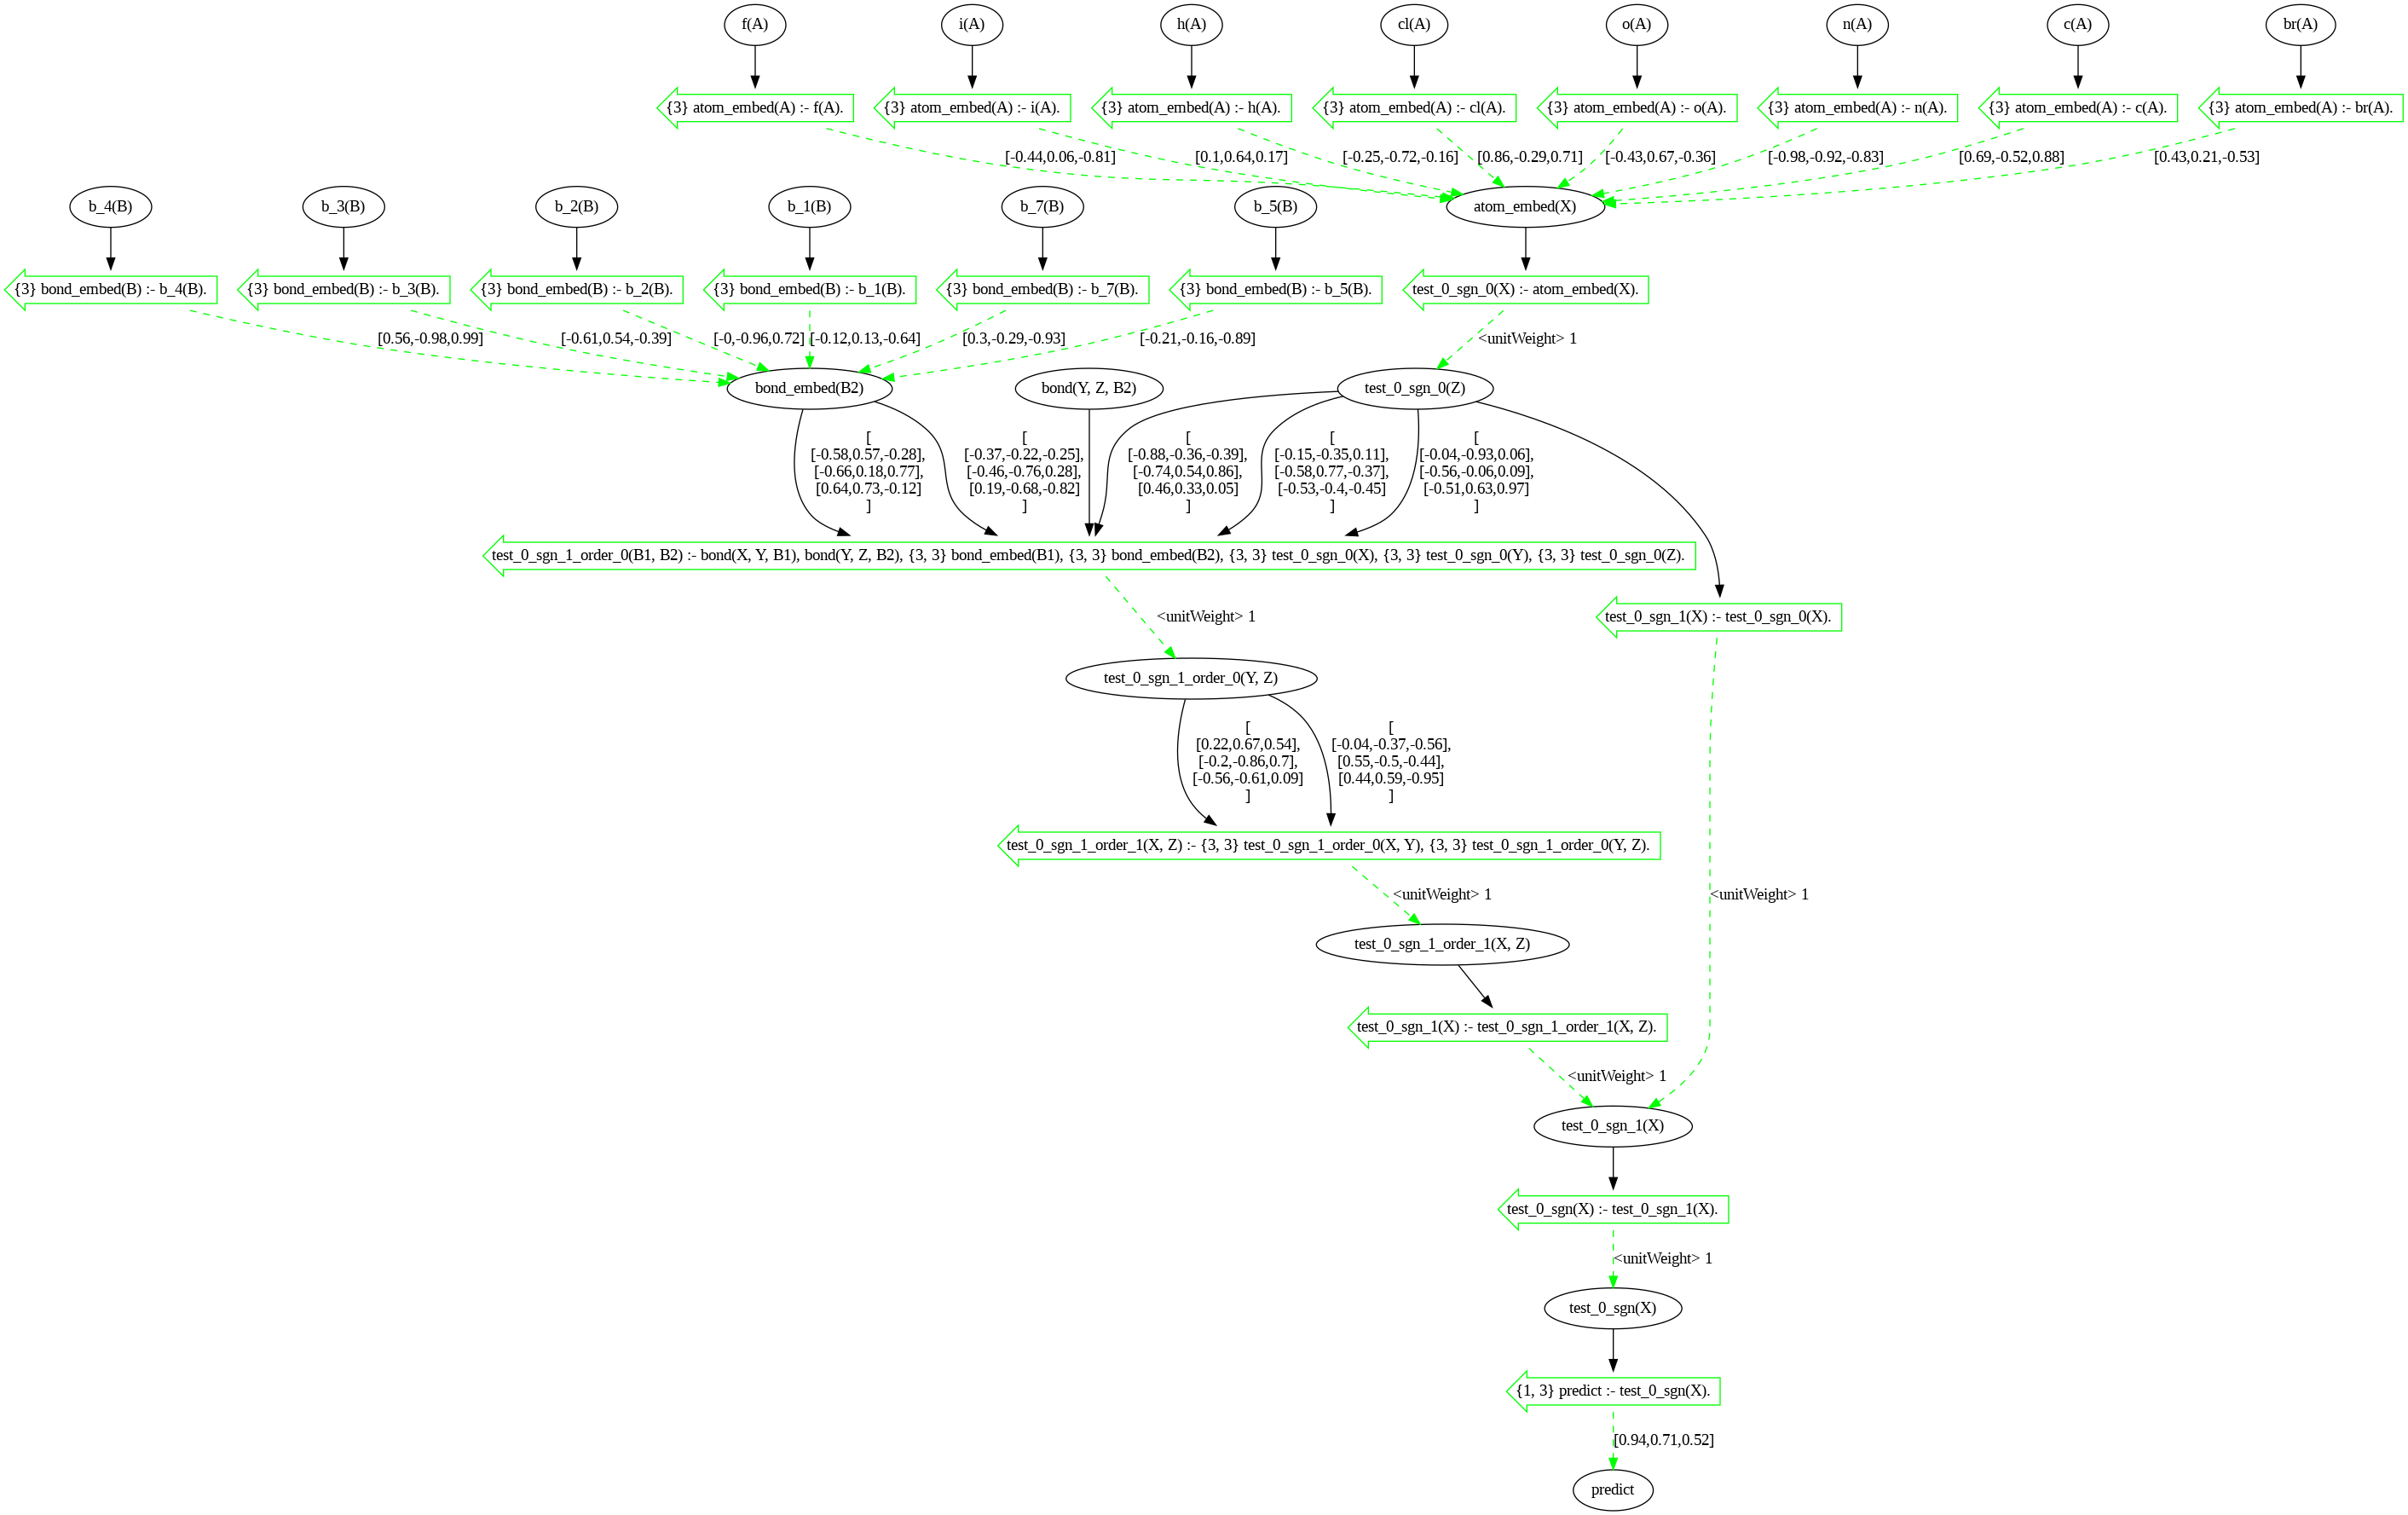

In [ ]:
template.draw()